# 1. Begin

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#ignore warning
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import pickle

## 1.1. Load and preprocess data

(1) Nhập dữ liệu vào và chuyển InvoiceNo sang dạng chữ để tìm ra điểm dĩ thường trong giá trị số

(2) Kiểm tra Info, Thông kê mô tả

(3) Loại bỏ null trong description

(4) Tìm hiểu về giá trị A và C trong InvoiceNo là gì

        A. LÀ KHÁCH HÀNG BỊ NHẬP LỖI

        C. LÀ KHÁCH HÀNG CANCELED

(5) Thấy sự trùng nhau:

        Unit Price < 0 -> Giá trị A

        Quantity < 0 -> Giá trị C (Nhưng liệu có phải tất cả giá trị Quantity < 0 đều ứng với InvoiceNo C**** k?)

(6) Câu trả lời là KHÔNG

Ko có C vẫn có Quantity < 0 và trong description ghi là hàng bị hỏng tức họ không Cancel hàng đơn giản là hàng hỏng nên không giao được

(7) Loại bỏ Quantity < 0 và UnitPrice < 0 và drop CustomedID bị NaN -> ra Dataframe 'data'

(8) Kiểm tra lại các tên trong Description của 'data' giờ đây đã là hàng hóa bình thường có thể bắt đầu tiến hành tạo RFM

In [2]:
def load_and_preprocess_data(file_path):

    df = pd.read_excel(file_path)
    # Convert 'InvoiceNo' to string to avoid issues with mixed types
    df['InvoiceNo'] = df['InvoiceNo'].astype(str)

    return df

Dictionary
- InvoiceNo: Mã hóa đơn. Mỗi số hóa đơn đại diện cho một giao dịch, có thể chứa nhiều dòng sản phẩm.

- StockCode: Mã sản phẩm. Dùng để định danh từng sản phẩm trong hệ thống.

- Description: Mô tả sản phẩm (tên sản phẩm bằng văn bản).

- Quantity: Số lượng sản phẩm được mua trong dòng giao dịch đó. Giá trị âm thường thể hiện việc trả hàng (returns).

- InvoiceDate: Ngày và giờ phát sinh hóa đơn (thời điểm giao dịch).

- UnitPrice: Đơn giá của từng sản phẩm (theo 1 đơn vị sản phẩm).

- CustomerID: Mã khách hàng duy nhất. Nếu bị thiếu thì đó là giao dịch không xác định được khách hàng.

- Country: Quốc gia của khách hàng.

In [3]:
df = load_and_preprocess_data('Online Retail.xlsx')

In [4]:
df.head(6)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
5 2010-12-01 08:26:00       7.65     17850.0  United Kingdom

In [5]:
df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

In [6]:
df.info()
#description và customerid có Nan cần xử lí

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
#locate where customerid is null
df[df['CustomerID'].isnull()]

InvoiceNo StockCode                      Description  Quantity  \
622       536414     22139                              NaN        56   
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

               InvoiceDate  UnitPrice  CustomerID         Country  
622    2010-12-01 11:52:00       0.00         NaN  United Kingdom  
1443   2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1444   2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1445   2010-12-01 14:32:00       0.85         NaN  United Kingdom  
1446   2010-12-01 14:32:00       1.66         NaN  United Kingdom  
...                    ...        ...         ...             ...  
541536 2011-12-09 10:26:00       4.13         NaN  United Kingdom  
541537 2011-12-09 10:26:00       4.13         NaN  United Kingdom  
541538 2011-12-09 10:26:00       4.96         NaN  United Kingdom  
541539 2011-12-09 10:26:00      10.79         NaN  United Kingdom  
541540 2011-12-09 10:26:00    1714.17         NaN  United Kingdom  

[135080 rows x 8 columns]

In [8]:
#locate where description is nan
df[df['Description'].isnull()]
#nếu description là nan thì chúng ta không biết khách hàng mua gì khi UnitPrice = 0
#dropnan description

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
622       536414     22139         NaN        56 2010-12-01 11:52:00   
1970      536545     21134         NaN         1 2010-12-01 14:32:00   
1971      536546     22145         NaN         1 2010-12-01 14:33:00   
1972      536547     37509         NaN         1 2010-12-01 14:33:00   
1987      536549    85226A         NaN         1 2010-12-01 14:34:00   
...          ...       ...         ...       ...                 ...   
535322    581199     84581         NaN        -2 2011-12-07 18:26:00   
535326    581203     23406         NaN        15 2011-12-07 18:31:00   
535332    581209     21620         NaN         6 2011-12-07 18:35:00   
536981    581234     72817         NaN        27 2011-12-08 10:33:00   
538554    581408     85175         NaN        20 2011-12-08 14:06:00   

        UnitPrice  CustomerID         Country  
622           0.0         NaN  United Kingdom  
1970          0.0         NaN  United Kingdom  
1971          0.0         NaN  United Kingdom  
1972          0.0         NaN  United Kingdom  
1987          0.0         NaN  United Kingdom  
...           ...         ...             ...  
535322        0.0         NaN  United Kingdom  
535326        0.0         NaN  United Kingdom  
535332        0.0         NaN  United Kingdom  
536981        0.0         NaN  United Kingdom  
538554        0.0         NaN  United Kingdom  

[1454 rows x 8 columns]

In [9]:
for col in df['Description'].unique():
    print(col)
#nhiều mục sai (mixed up, lost, missing, ???? need, gift, test, sample, damaged, error)
# Cùng tìm hiểu nó là gì nào

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

In [10]:
df = df.dropna(subset=['Description'])

In [11]:

#find not normal 6 digits invoice
df[df['InvoiceNo'].str.match('^\d{6}$') == False]
#ALl non-6 digits invoice have C before their No
# Chúng ta thấy các customer này thường có quantity là âm, hãy kiểm tra nó xem
 #C must be Cancel customer

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  
141    2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154    2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235    2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236    2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237    2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
...                    ...        ...         ...             ...  
540449 2011-12-09 09:57:00       0.83     14397.0  United Kingdom  
541541 2011-12-09 10:28:00     224.69     15498.0  United Kingdom  
541715 2011-12-09 11:57:00      10.95     15311.0  United Kingdom  
541716 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  
541717 2011-12-09 11:58:00       1.25     17315.0  United Kingdom  

[9291 rows x 8 columns]

In [12]:
Damage_customers = df[df['InvoiceNo'].str.match('^\d{6}$') == True & (df['Quantity'] < 0)]
# Damage_customers['Description'].unique().tolist()
# Description đều báo lỗi chứng tỏ các các khách hàng này là Damages/Stock Corrections

In [13]:
Cancel_customers = df[df['InvoiceNo'].str.match('^\d{6}$') == False & (df['Quantity'] < 0)]
# Cancel_customers
#Description bình thường chứng tỏ đây là nhóm rời bỏ Churn
#Sau khi phân cụm xong nhóm này sẽ là Cancel

In [14]:
df[df['UnitPrice'] < 0]
#Unit price < 0 is simply wrong value we will drop it
# A này có thể là khách hàng bị đuổi vì nợ xấu
# 2 dòng này sẽ bị loại khỏi bài đến cuối cùng luôn

InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

In [15]:
df.dropna(subset=['CustomerID'], inplace=True)

In [16]:
#lấy df khi quantity và unitprce >0
data = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [17]:
for col in data['Description'].unique():
    print(col)
#các mục sai đã hết sau khi drop quantity < 0

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

In [18]:
# Số cột mà sau khi grouby sẽ có
data['CustomerID'].nunique()

4338

## 1.2. Feature Engineering
(Đây sẽ là 3 biến được sử dụng chính cho mô hình phân cụm Kmeans)

(1) Recency: TÍnh bằng ngày cuối cùng (max) của toàn bộ dataset + 1(để thể hiện nó là ngày đang phân tích)- đi cho x ( là ngày cao nhất (cuối) của từng khách hàng sau khi )

Nếu khách hàng vừa mua gần đây → số ngày nhỏ.

Nếu khách hàng lâu không mua → số ngày lớn.

(2) Frequency: Là số giá trị count của invoice no tuy nhiên thì tất cả các InvoiceNo diễn ra trong cùng 1 ngày

-> lấy count ko thể hiện được là tần suất thật sự của người mua

`-> count distinct

(3) Monetary: Là tổng của Total Price cho từng khách hàng

In [21]:
def calculate_total_price(data):
    data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
    return data
data = calculate_total_price(data)
data.head(2)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34

In [22]:
import datetime as dt
def create_rfm_features(df):
    snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

    # RFM
    rfm = data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,           # Recency
        'InvoiceNo': 'nunique',         # Frequency
        'TotalPrice': 'sum'             # Monetary
    }).reset_index()

    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    return rfm

rfm = create_rfm_features(data)
rfm.head()


CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   float64
 1   Recency     4338 non-null   int64  
 2   Frequency   4338 non-null   int64  
 3   Monetary    4338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 135.7 KB


# 2. Exploratory Data Analysis

## 2.1. Trend and Seasonality

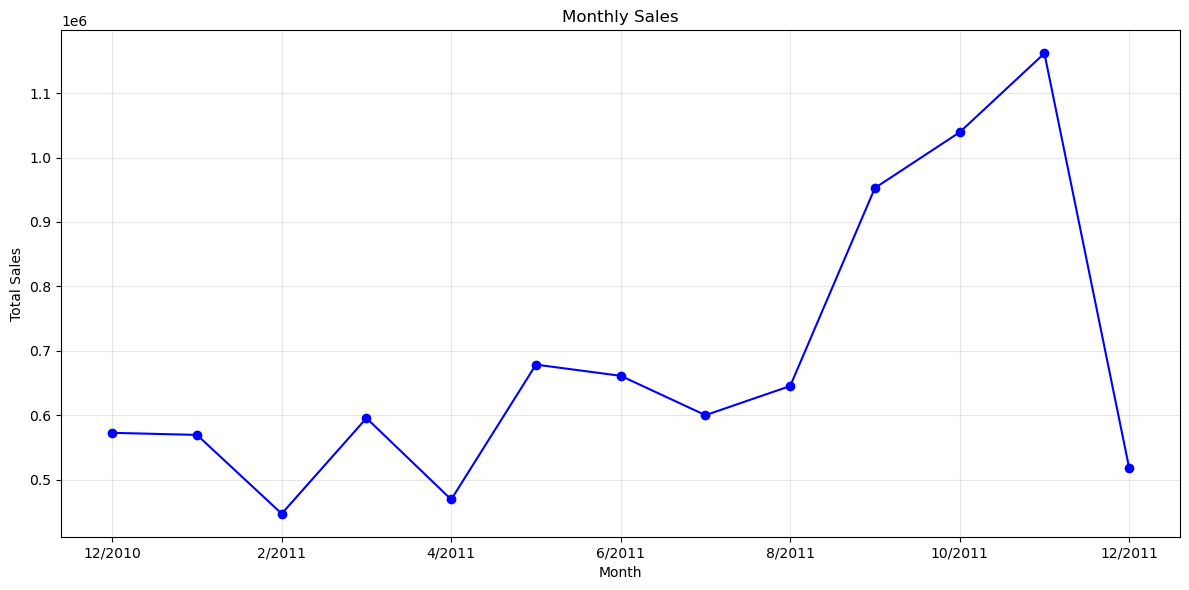

In [23]:
plt.figure(figsize=(12, 6))
monthly_sales = data.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()

# Plot with month numbers
plt.plot(range(len(monthly_sales)), monthly_sales.values, marker='o' , color = 'blue')

# Show every other month label
plt.xticks(range(0, len(monthly_sales), 2), 
[f'{date.month}/{date.year}' for date in monthly_sales.index][::2])

plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Trong năm 2011, doanh số duy trì ở mức trung bình trong hầu hết các tháng, nhưng tăng đột biến rõ rệt từ tháng 9 đến tháng 11, đạt đỉnh vào tháng 11. Đây là xu hướng “đường cong khúc gậy hockey”, nhiều khả năng đến từ:

- Nhu cầu mua sắm dịp lễ hội cuối năm (Giáng sinh ở Anh).

- Doanh nghiệp tiến hành xả hàng tồn kho.

- Nhân viên kinh doanh chạy chỉ tiêu, thưởng và quota cuối năm.

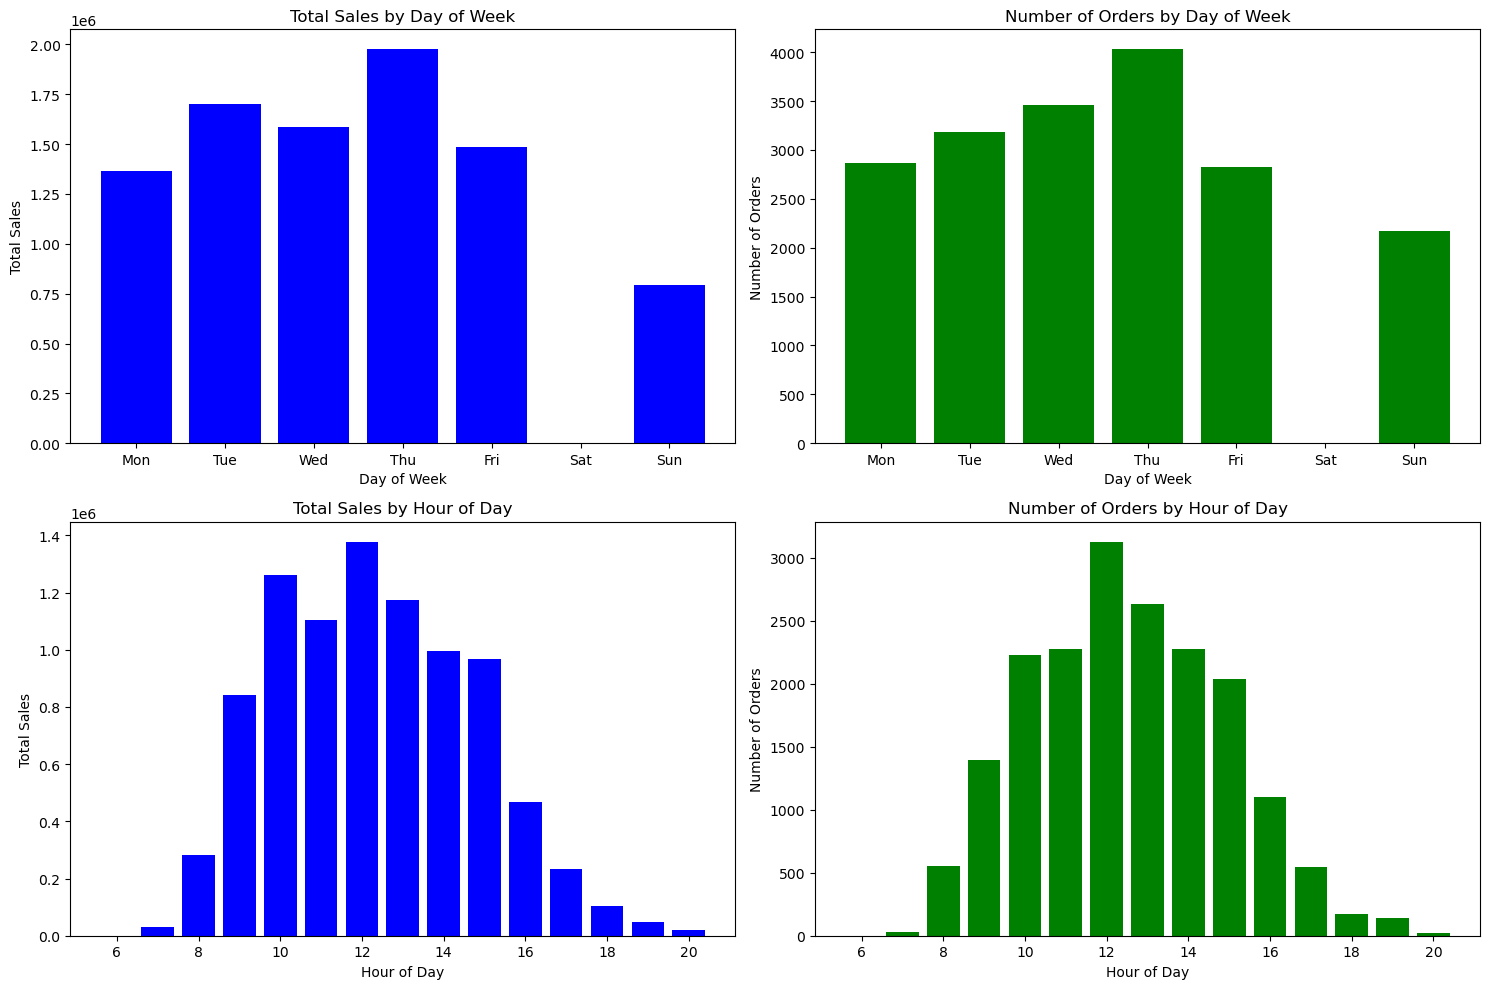

In [ ]:
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
data['HourOfDay'] = data['InvoiceDate'].dt.hour

dayofweek_sales = data.groupby('DayOfWeek')['TotalPrice'].sum()
dayofweek_orders = data.groupby('DayOfWeek')['InvoiceNo'].nunique()
hourofday_sales = data.groupby('HourOfDay')['TotalPrice'].sum()
hourofday_orders = data.groupby('HourOfDay')['InvoiceNo'].nunique()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Total Sales by Day of Week
axes[0, 0].bar(dayofweek_sales.index, dayofweek_sales.values, color = 'blue')
axes[0, 0].set_title('Total Sales by Day of Week')
axes[0, 0].set_xlabel('Day of Week')
axes[0, 0].set_ylabel('Total Sales')
axes[0, 0].set_xticks(range(7)) # Set ticks for all 7 days
axes[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


# Plot Number of Orders by Day of Week
axes[0, 1].bar(dayofweek_orders.index, dayofweek_orders.values, color = 'green')
axes[0, 1].set_title('Number of Orders by Day of Week')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].set_xticks(range(7)) # Set ticks for all 7 days
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plot Total Sales by Hour of Day
axes[1, 0].bar(hourofday_sales.index, hourofday_sales.values, color='blue')
axes[1, 0].set_title('Total Sales by Hour of Day')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Total Sales')


# Plot Number of Orders by Hour of Day
axes[1, 1].bar(hourofday_orders.index, hourofday_orders.values, color = 'green')
axes[1, 1].set_title('Number of Orders by Hour of Day')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Number of Orders')


plt.tight_layout()
plt.show()

Hoạt động bán hàng (cả về doanh số và số lượng đơn hàng) có sự biến động đáng kể theo cả ngày trong tuần và giờ trong ngày.
1. Theo ngày trong tuần:

- Thứ Năm là ngày có tổng doanh số và số lượng đơn hàng cao nhất. Điều này cho thấy khách hàng có xu hướng mua sắm nhiều nhất vào giữa tuần, có thể liên quan đến các chương trình khuyến mãi hoặc thói quen mua sắm trước cuối tuần.
- Thứ Bảy có doanh số và số lượng đơn hàng thấp nhất. Điều này khá hợp lý vì có thể đây là ngày nghỉ của cửa hàng hoặc khách hàng có xu hướng thực hiện các hoạt động khác vào cuối tuần thay vì mua sắm trực tuyến từ cửa hàng này.
- Các ngày khác trong tuần (Thứ Hai, Thứ Ba, Thứ Tư, Thứ Sáu) có mức doanh số và số lượng đơn hàng tương đối ổn định, thấp hơn Thứ Năm nhưng cao hơn Thứ Bảy.
2. Theo giờ trong ngày:

- Hoạt động bán hàng tập trung chủ yếu vào giờ hành chính, từ khoảng 9 giờ sáng đến 4 giờ chiều (16 giờ).
- 12 giờ trưa (12h) là giờ có tổng doanh số và số lượng đơn hàng cao nhất. Đây là thời điểm khách hàng có thể tranh thủ giờ nghỉ trưa để mua sắm.
- Có một sự sụt giảm đáng kể về doanh số và đơn hàng vào cuối giờ chiều và tối.
- Có rất ít hoặc không có hoạt động bán hàng vào các giờ ngoài giờ hành chính và ban đêm.

## 2.2 Phân tích theo Địa Lý (Geographical Analysis)

### 2.2.1 Function for Distribution Plot

In [ ]:

def plot_top_countries(data, grp ,col, n):
    country_sales = data.groupby(grp)[col].sum().sort_values(ascending=False)
    top_countries = country_sales.head(n)

    total_sales_top_countries = country_sales.sum()
    percentage_contribution = (top_countries / total_sales_top_countries) * 100

    colors = ['lightgreen', 'red', 'blue', 'orange', 'purple']

    ax = percentage_contribution.plot(kind='barh', color=colors)
    plt.title(f'Top 5 by {grp} Percentage Contribution to {col}')
    plt.xlabel(f'Percentage Contribution to {col}')
    plt.ylabel(f'{grp}')
    plt.grid()

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')
    plt.show()
    
def plot_least(data, grp ,col, n):
    country_sales = data.groupby(grp)[col].sum().sort_values(ascending=True)
    top_countries = country_sales.head(n)

    total_sales_top_countries = country_sales.sum()
    percentage_contribution = (top_countries / total_sales_top_countries) * 100

    colors = ['lightgreen', 'red', 'blue', 'orange', 'purple']

    ax = percentage_contribution.plot(kind='barh', color=colors)
    plt.title(f'Top 5 by {grp} Percentage Contribution to {col}')
    plt.xlabel(f'Percentage Contribution to {col}')
    plt.ylabel(f'{grp}')
    plt.grid()

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')
    plt.show()

### 2.2.2 Sales Distribution by Country

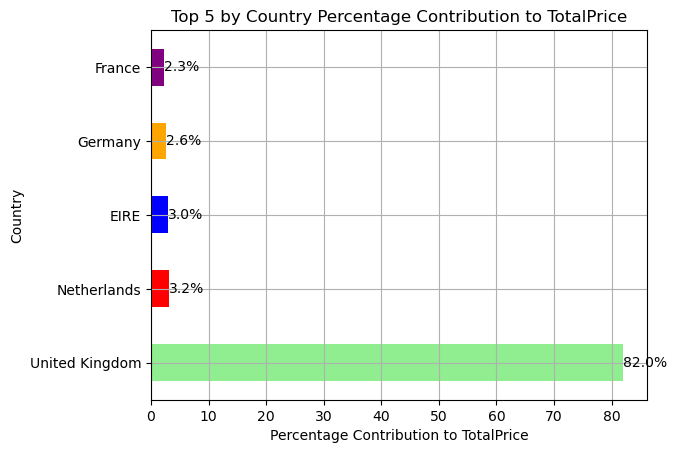

In [ ]:
# PLOTTING PERCENTAGE ON GRAPH TO SHOW HOW MUCH DIFFERENT COUNTRIES CONTRIBUTE TO THE SALES
plot_top_countries(data, 'Country','TotalPrice', 5)

The business has a high dependency on the UK market, which contributes approximately 88.1% of total sales.
While this could indicate market expertise, it also presents a risk of over-reliance on a single country; geopolitical crises or changes in regulations could significantly impact the business.
Diversification into other countries is suggested to mitigate this risk, or a strong focus on providing excellent service to UK customers if diversification is not a priority.

### 2.2.3 Customers Distribution by Country

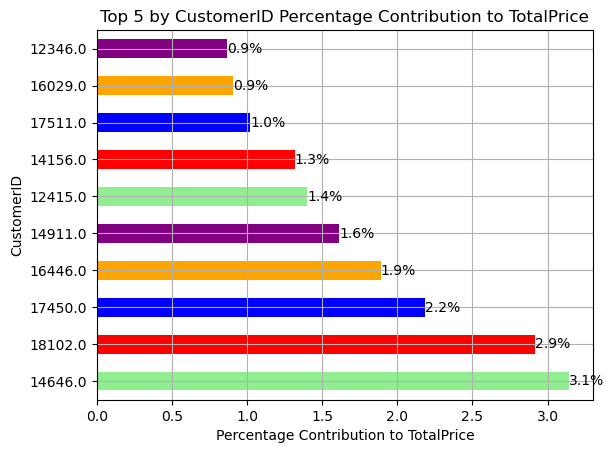

In [ ]:
# PLOT TO SEE 10 BEST CUSTOMERS OF THE STORES
plot_top_countries(data, 'CustomerID','TotalPrice', 10)


## 2.3. Phân tích sản phẩm (Product Performance Analysis)

### 2.3.1 Sản phẩm bán chạy (Top Products)

Sản phẩm bán chạy nhất, “PAPER CRAFT”, chỉ chiếm khoảng 1,9% trong tổng doanh số sản phẩm.

Điều này cho thấy danh mục sản phẩm của công ty khá đa dạng, không phụ thuộc quá mức vào một mặt hàng duy nhất – đây là một tín hiệu tích cực cho sự ổn định trong kinh doanh.

Top 10 Most Sold Products (by Quantity):
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64


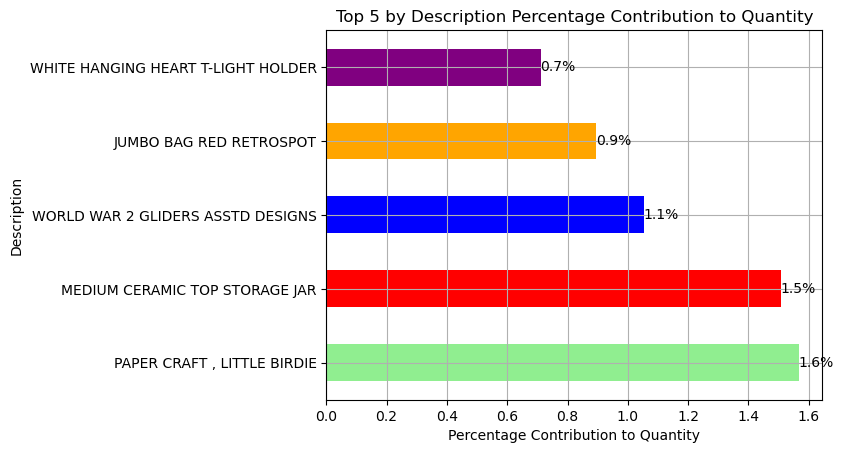


Top 10 Most Sold Products (by Total Price):
Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                     51346.20
Name: TotalPrice, dtype: float64


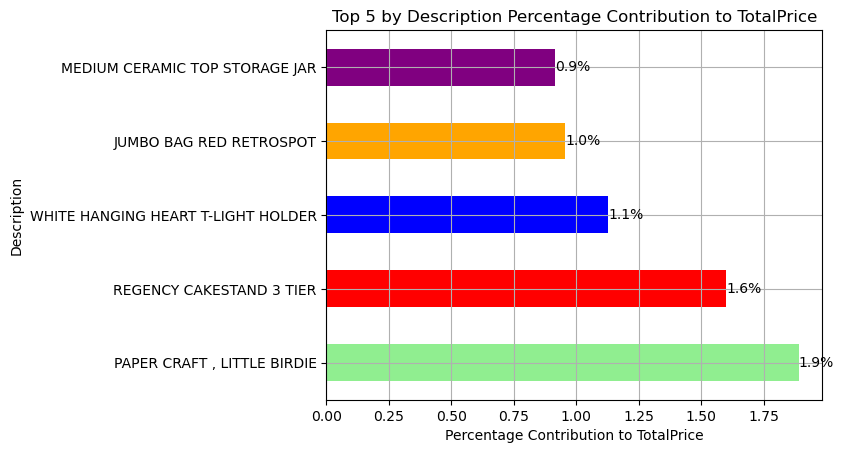

In [ ]:
# Identify top 10 most sold products by quantity
top_selling_products_quantity = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

print("Top 10 Most Sold Products (by Quantity):")
print(top_selling_products_quantity)

# PLOT TO SEE THE 5 BEST PRODUCTS 
plot_top_countries(data, 'Description','Quantity', 5)

# Identify top 10 most sold products by total price
top_selling_products_price = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

print("\nTop 10 Most Sold Products (by Total Price):")
print(top_selling_products_price)


plot_top_countries(data, 'Description','TotalPrice', 5)


### 2.3.2 Sản phẩm kẹm chạy (Least Products)

In [ ]:
# Identify 10 least sold products by quantity
least_selling_products_quantity = data.groupby('Description')['Quantity'].sum().sort_values(ascending=True).head(5)

print("\n10 Least Sold Products (by Quantity):")
print(least_selling_products_quantity)
# Insight: Có nhiều sản phẩm chỉ bán được số lượng rất ít (chỉ 1 sản phẩm), có thể cần xem xét lại việc duy trì các mặt hàng này trong kho.

# plot_least(data, 'Description','Quantity', 5)

# Identify 10 least sold products by total price
least_selling_products_price = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=True).head(5)

print("\n10 Least Sold Products (by Total Price):")
print(least_selling_products_price)
# Insight: Một số sản phẩm có tổng doanh thu rất thấp, thậm chí gần bằng 0, điều này có thể là do giá trị đơn vị thấp hoặc số lượng bán ra không đáng kể.

# plot_least(data, 'Description','TotalPrice', 5)


10 Least Sold Products (by Quantity):
Description
 I LOVE LONDON MINI RUCKSACK         1
VINTAGE BEAD PINK JEWEL STAND        1
AMBER BERTIE GLASS BEAD BAG CHARM    1
HEN HOUSE W CHICK IN NEST            1
CHERRY BLOSSOM PURSE                 1
Name: Quantity, dtype: int64

10 Least Sold Products (by Total Price):
Description
PADS TO MATCH ALL CUSHIONS         0.003
HEN HOUSE W CHICK IN NEST          0.420
SET 12 COLOURING PENCILS DOILEY    0.650
VINTAGE BLUE TINSEL REEL           0.840
PINK CRYSTAL GUITAR PHONE CHARM    0.850
Name: TotalPrice, dtype: float64


## 2.4. Explore Cancellations and Returns

In [ ]:
# Analyze cancelled orders
cancelled_orders = df[df['InvoiceNo'].str.contains('C', na=False)]

print("Number of cancelled orders:", len(cancelled_orders))
print("\nSample of cancelled orders:")
display(cancelled_orders.head())

# Phân tích tác động của việc hủy đơn hàng lên tổng doanh số (tùy vào việc mình định nghĩa tác động này là gì)
# Vd có thể so sánh tổng doanh số trước và sau khi xóa các đơn hàng đã hủy

Number of cancelled orders: 8905

Sample of cancelled orders:


InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom

## 2.5. Phân bố RFM

Từ hình vẽ chúng ra có thể thấy rằng data khác biệt rõ ràng từ khoảng 100-150 ngày trở đi

-> Vậy ta sẽ đặt 1 ngưỡng threshold là 150, nếu khách hàng ko mua hàng quá 150 có thể coi đấy là Churn

---Liệu Model Machine Learning có gọi đây là 1 cluster không?

In [ ]:
customer_last_purchase = rfm['Recency']
churn_threshold = 150 # Tạo ngưỡng rời bỏ là 150
churn_customers = rfm[customer_last_purchase > churn_threshold]
churn_customers.shape

(1041, 4)

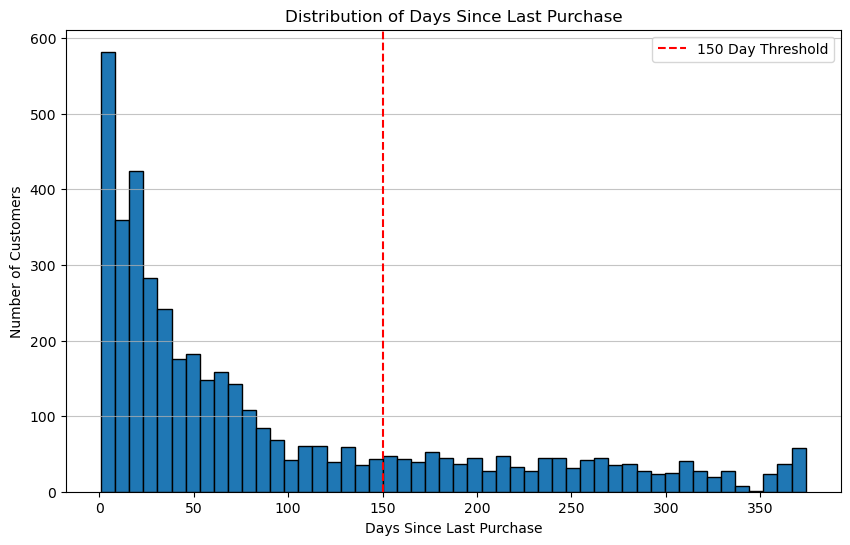

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(customer_last_purchase, bins=50, edgecolor='black')
plt.axvline(x=150, color='red', linestyle='--', label='150 Day Threshold')
plt.title('Distribution of Days Since Last Purchase')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

### 2.6. Kiểm tra NaN và Outliers trong dữ liệu RFM (cần thiết cho build model)

RFM Không có Nan 

RFM có quá nhiều outliers ở Frequenct và Monetary khiến IQR range bị co hẹp vào trong hình vẽ -> Cần xử lý

### 2.6.1. Kiểm tra NaN value

In [26]:
rfm.isnull().sum()

CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64

### 2.6.2. Kiểm tra Outliers

In [28]:
rfm.describe()

CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

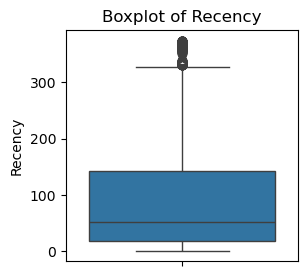

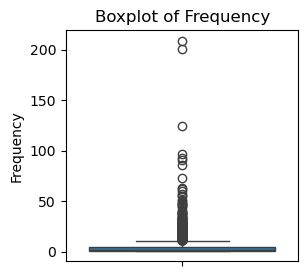

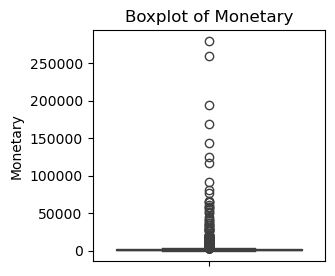

In [27]:
# Plotting boxplots for R, F, M
def plot_boxplot(column, data):
    plt.figure(figsize=(3, 3))
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
    #plt.ylim(lower_bound - 10, upper_bound + 10)
    plt.show()

for col in ['Recency', 'Frequency', 'Monetary']:
    plot_boxplot(col, rfm)

# R không nhiều outlier
# F, M có nhiều outlier cần bỏ đi để tiến hành phân cụm
# -3 : Nhóm có outlier F nhưng ko có M
# -2: Nhóm có outlier M nhưng ko có F
# -1: Nhóm có cả 2 outlier

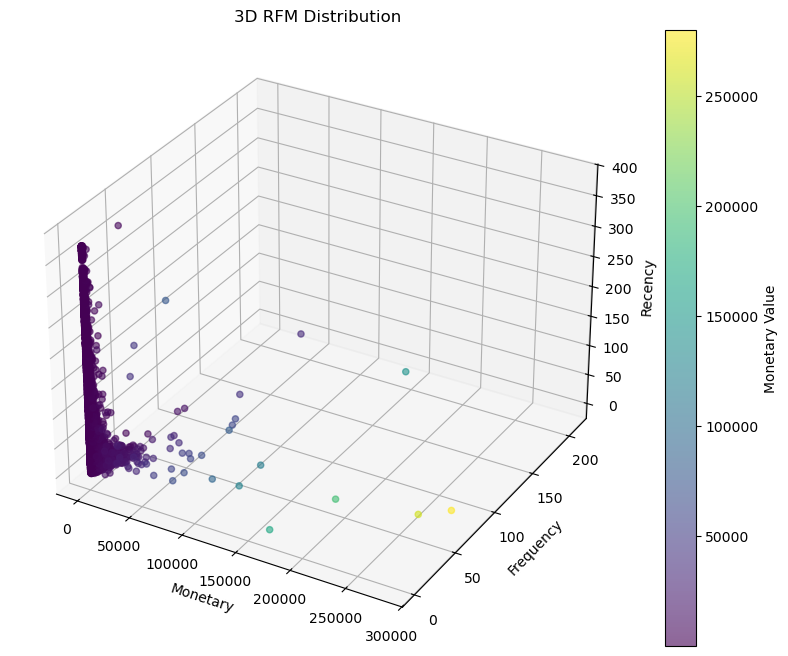

In [25]:
def plot_3d_rfm(df):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(df['Monetary'],
                        df['Frequency'],
                        df['Recency'],
                        c=df['Monetary'],
                        cmap='viridis',
                        alpha=0.6)

    ax.set_xlabel('Monetary')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Recency')
    
    plt.colorbar(scatter, label='Monetary Value')
    plt.title('3D RFM Distribution')
    plt.show()

plot_3d_rfm(rfm)
# Có quá nhiều outlier cần phải được xử lí

### 2.6.3. Xử lí Outliers
#### Có 3 df mới là: 
#### - rfm 
#### - outliers_df 
#### - non_outliers_df

Từ kết quả xử lí Outliers ta có thể thấy:

(1) Tạo ra 2 function 1 để lấy ra data non_outliers và outliers (cả 2 đều sẽ được sử dụng trong bài)

(2) Mục tiêu với non_outliers: 

        - Sử dụng cho Kmeans (vì rất nhạy cảm với outliers)

        - Tìm xem không log hay log đem đến kết quả cluster tốt hơn nhờ các metric: Dunn, CH, DBI, Si score

        - Sau khi phân cụm sẽ kết hợp với cụm của data có Outliers: Outlier của Frequency, Outliers của Monetary và Outliers của Cả 2

(3) Sử dụng rfm chưa xử lí outlier với DBSCAN 

In [59]:
#function for only outliers
def outlier_dataframe(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] < lower_bound) | (data[col] > upper_bound)]

#function for only non outliers
def non_outlier_dataframe(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

f_outliers = outlier_dataframe(rfm, 'Frequency')
m_outliers = outlier_dataframe(rfm, 'Monetary')

f_non_outliers = non_outlier_dataframe(rfm['Frequency'])
m_non_outliers = non_outlier_dataframe(rfm['Monetary'])

In [60]:
#put a non_outliers_df of what index is in f_non_outliers and m_non_outliers
non_outliers_df = rfm[rfm['Frequency'].isin(f_non_outliers) & rfm['Monetary'].isin(m_non_outliers)]
non_outliers_data = non_outliers_df.copy()

In [61]:
non_outliers_df.drop(columns=[ 'CustomerID'], inplace=True)

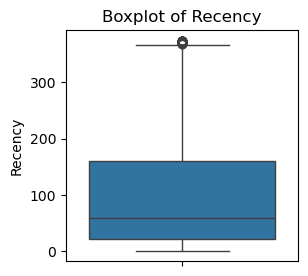

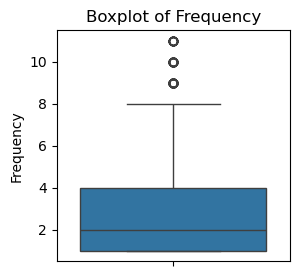

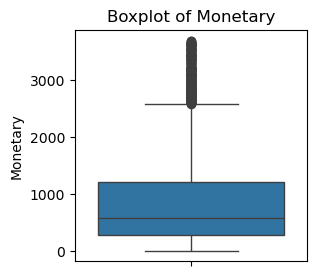

In [62]:
for col in ['Recency', 'Frequency', 'Monetary']:
    plot_boxplot(col, non_outliers_df)
#các box mới đã đỡ xẹp hơn

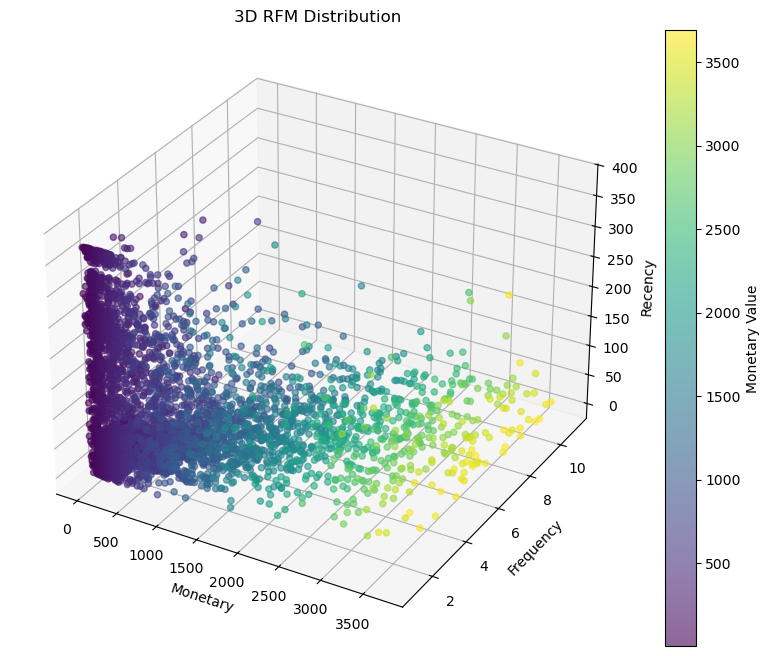

In [63]:
plot_3d_rfm(non_outliers_df)

### 2.6.4. Xem xét RFM xem data có skewed không? Nếu có xử dụng Log Transform

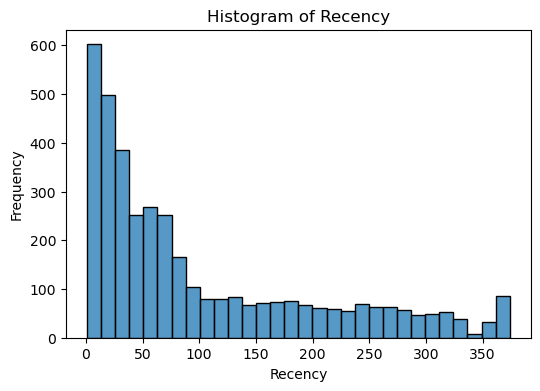

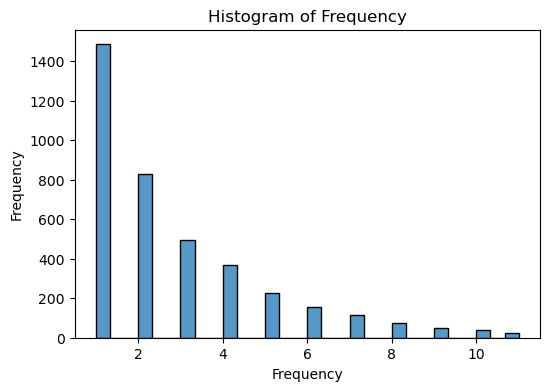

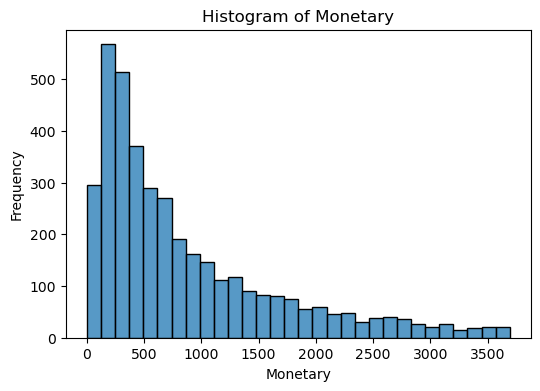

In [64]:
#plot histogram non_outliers_df
for col in non_outliers_df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(non_outliers_df[col], bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

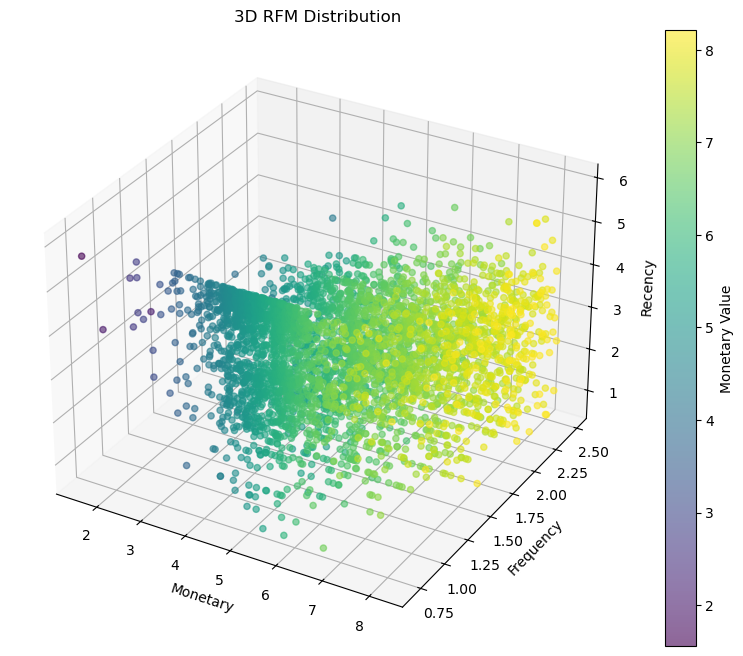

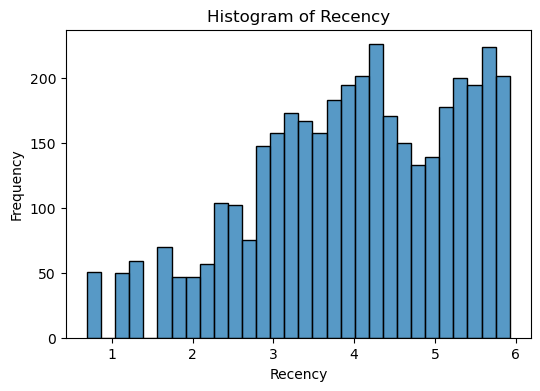

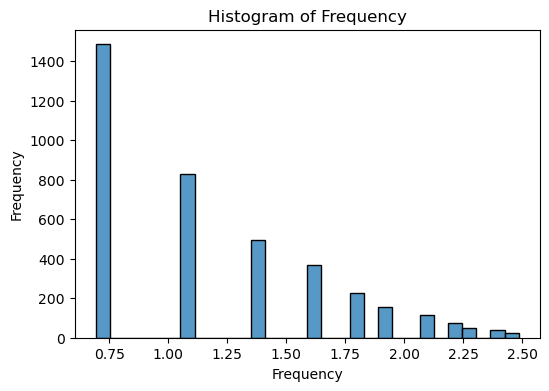

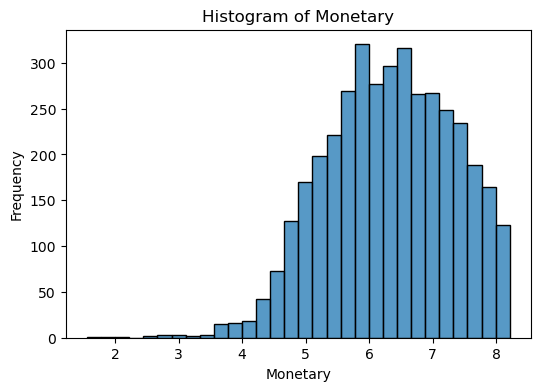

In [65]:
def log_transform(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df_log = df.copy()
    df_log[numeric_cols] = np.log1p(df_log[numeric_cols])
    return df_log

non_outliers_df_log = log_transform(non_outliers_df)

plot_3d_rfm(non_outliers_df_log)

for col in non_outliers_df_log.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(non_outliers_df_log[col], bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# 3. Xây dựng mô hình học máy (Build ML Model)

## 3.1. Normalization

### 3.1.1 StandardScaler

In [66]:
def standard_scale(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

standard_scale(non_outliers_df_log)

standard_scale(non_outliers_df)

standard_scale(rfm)

CustomerID   Recency  Frequency  Monetary
0      -1.716073  2.334574  -0.425097  8.358668
1      -1.715492 -0.905340   0.354417  0.250966
2      -1.714911 -0.175360  -0.035340 -0.028596
3      -1.714330 -0.735345  -0.425097 -0.033012
4      -1.713749  2.174578  -0.425097 -0.191347
...          ...       ...        ...       ...
4333    1.730701  1.854587  -0.425097 -0.208459
4334    1.731282  0.884612  -0.425097 -0.219560
4335    1.731863 -0.845342  -0.295178 -0.208742
4336    1.732443 -0.885341   1.523687  0.004519
4337    1.734767 -0.495351  -0.165259 -0.024141

[4338 rows x 4 columns]

### 3.1.2 Min Max Scaler

In [67]:
# def min_max_scale(df):
#     numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
#     scaler = MinMaxScaler()
#     df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
#     return df

# min_max_scale(non_outliers_df_log)

# min_max_scale(non_outliers_df)

# min_max_scale(rfm)
# rfm.drop(columns = 'CustomerID', inplace = True, axis = 1)

## 3.2. KMeans Model


### 3.2.1 WCSS

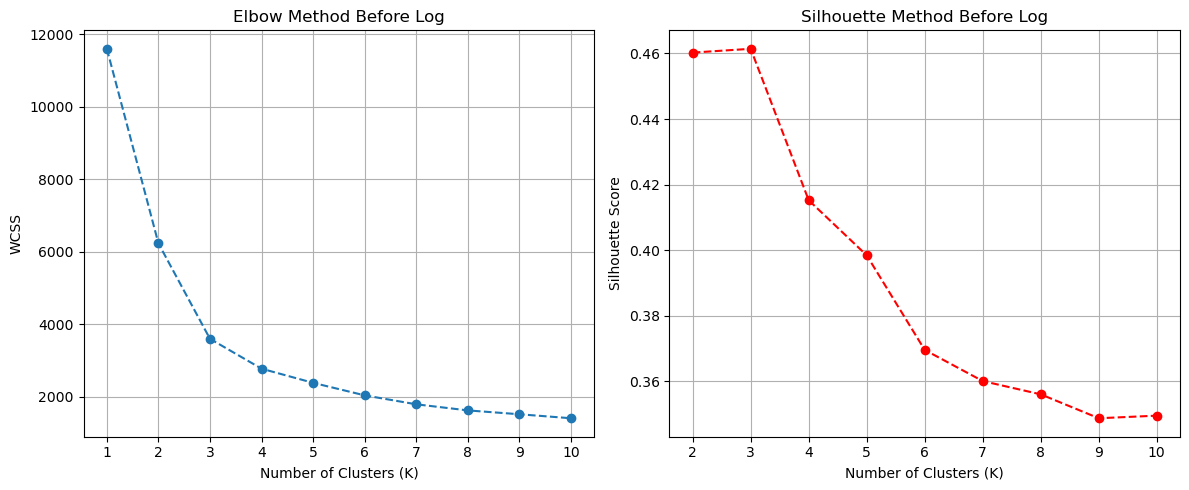

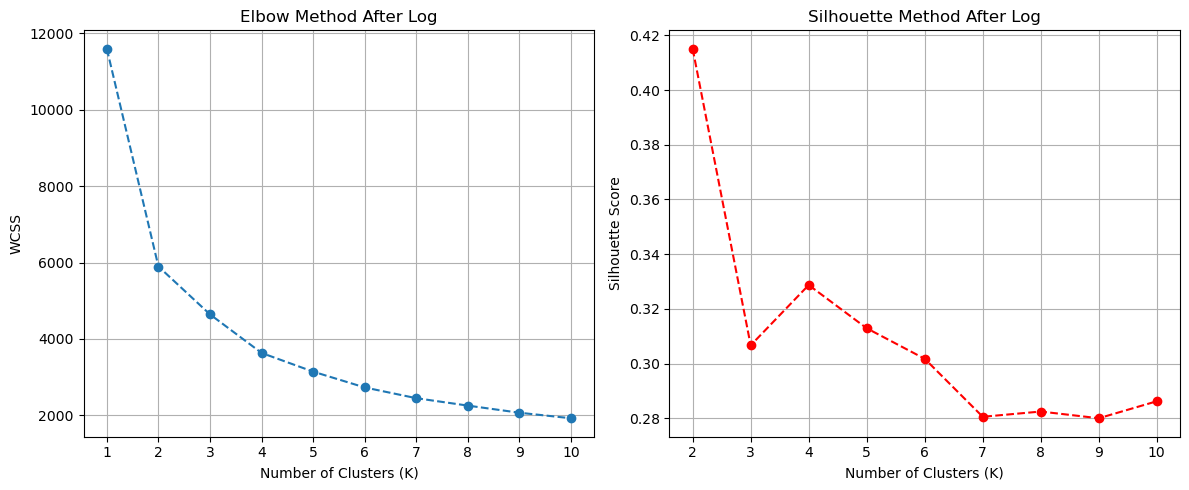

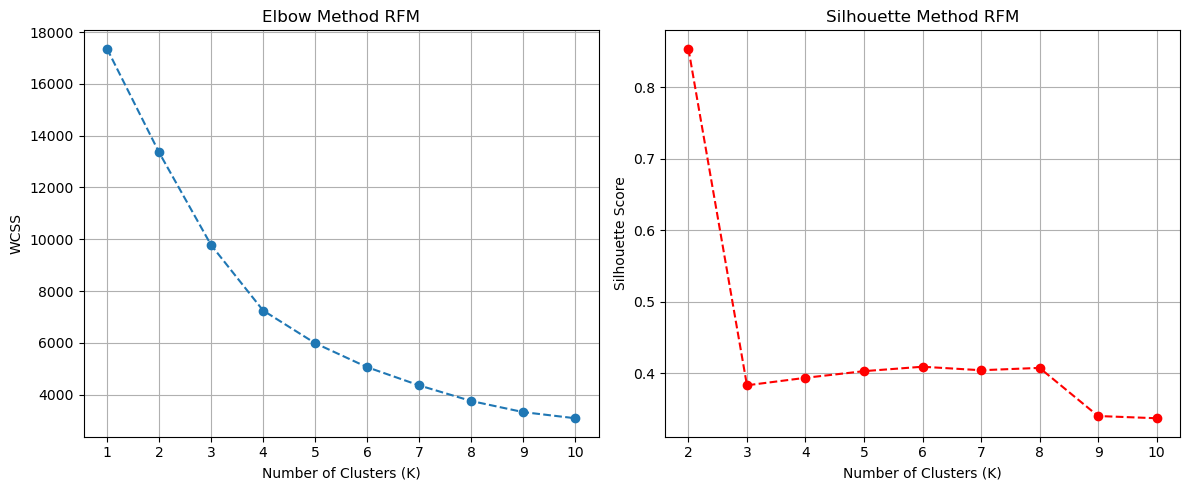

In [98]:
#Đơn thuần là gán giá trị để đặt tên phân biệt, không gọi hàm
non_outliers_df.name = 'Before Log'
non_outliers_df_log.name = 'After Log'
rfm.name = "RFM"
def find_optimal_k_wcss(data, max_k):
    wcss = []
    for i in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot WCSS
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
    plt.title(f'Elbow Method {data.name}')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)

    # Calculate silhouette scores
    silhouette_scores = []
    for i in range(2, max_k + 1):  # Silhouette score needs at least 2 clusters
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))

    # Plot Silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='--', color = 'red')
    plt.title(f'Silhouette Method {data.name}')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, max_k + 1))
    plt.grid(True)
    plt.tight_layout()

# Example usage (replace non_outliers_df_log with your data)
# You might want to experiment with different max_k values
find_optimal_k_wcss(non_outliers_df, 10)

find_optimal_k_wcss(non_outliers_df_log, 10)

find_optimal_k_wcss(rfm, 10)

# Silhouette accuracy after Log is significantly lower than before log -> Choose Before log
# choosing k=3

### 3.2.2 FUNCTION TO USE KMEANS

In [93]:
def perform_kmeans_clustering(data, n_clusters):
    # Model
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data)
    labels = kmeans.labels_

    #3 basic index
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)

    # Dunn Index
    distances = euclidean_distances(data)

    ## Max intra-cluster distance (diameter)
    max_intra = 0
    for cluster in np.unique(labels):
        cluster_idx = np.where(labels == cluster)[0]
        if len(cluster_idx) > 1:
            intra_dist = distances[np.ix_(cluster_idx, cluster_idx)].max()
            max_intra = max(max_intra, intra_dist)

    ## Min inter-cluster distance
    min_inter = np.inf
    unique_labels = np.unique(labels)
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i_idx = np.where(labels == unique_labels[i])[0]
            cluster_j_idx = np.where(labels == unique_labels[j])[0]
            inter_dist = distances[np.ix_(cluster_i_idx, cluster_j_idx)].min()
            min_inter = min(min_inter, inter_dist)

    dunn_index = min_inter / max_intra if max_intra > 0 else 0

    #Print
    print(f"Silhouette Score: {silhouette}")
    print(f"Calinski-Harabasz Score: {calinski}")
    print(f"Davies-Bouldin Score: {davies}")
    print(f"Dunn Index: {dunn_index}")

    #Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data.iloc[:, 2], data.iloc[:, 1], data.iloc[:, 0], c=labels)
    ax.set_title('K-Means Clustering Results (3D)')
    ax.set_xlabel('Monetary')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('R')
    plt.show()

    #PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])
    pca_df['cluster'] = labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=pca_df, palette='viridis', legend='full')
    plt.title('K-Means Clustering Results (PCA)')
    plt.show()

    return labels, kmeans 

Khi sử dụng DUNN INDEX vào mô hình Kmeans khiến cho max intra bị phình to ra -> Dunn Index nhỏ
Chỉ kỳ vọng dunn index trong khoảng 0.001 đến 0.2

#### 3.2.2.1. RFM still have Outliers

Silhouette Score: 0.39370733814111564
Calinski-Harabasz Score: 2014.1856295177483
Davies-Bouldin Score: 0.8597680060471208
Dunn Index: 0.0010132696113309902


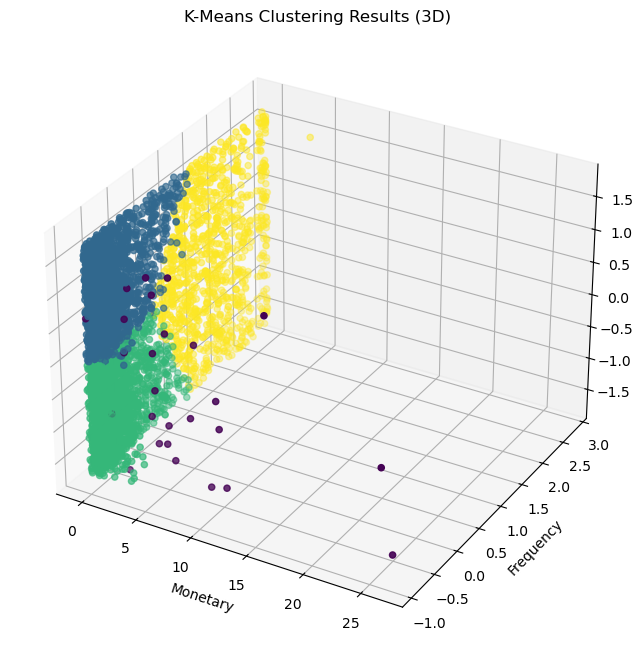

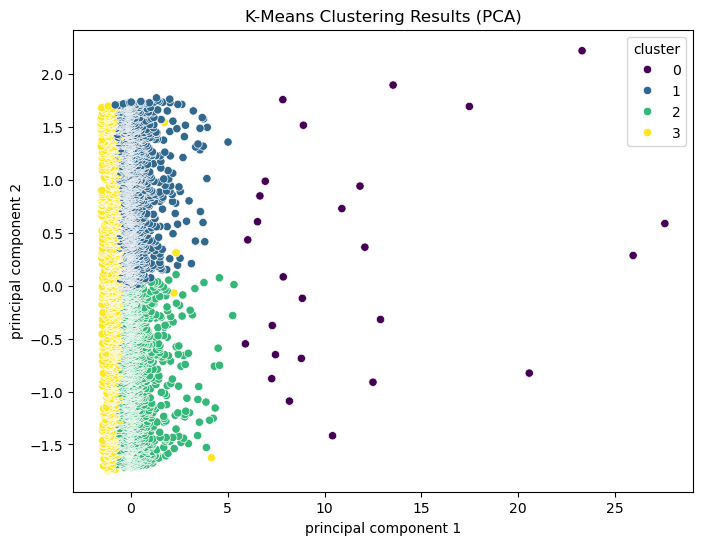

In [94]:
labels_rfm, kmeans_rfm = perform_kmeans_clustering(rfm, n_clusters=4)

Bị ảnh hưởng nhiều bởi outliers dữ liệu chồng chéo lên nhau

#### 3.2.2.2. RFM with no outliers

Silhouette Score: 0.41521793186482303
Calinski-Harabasz Score: 4090.8203475113824
Davies-Bouldin Score: 0.8901213817607687
Dunn Index: 0.0062009455746722345


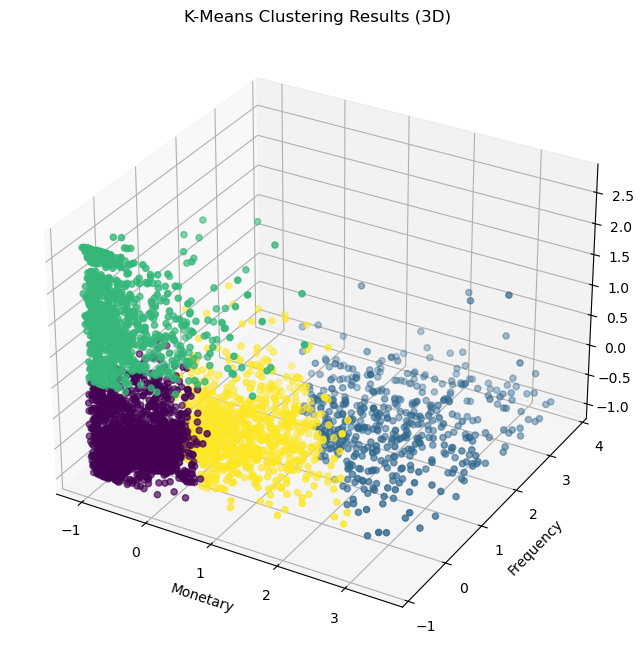

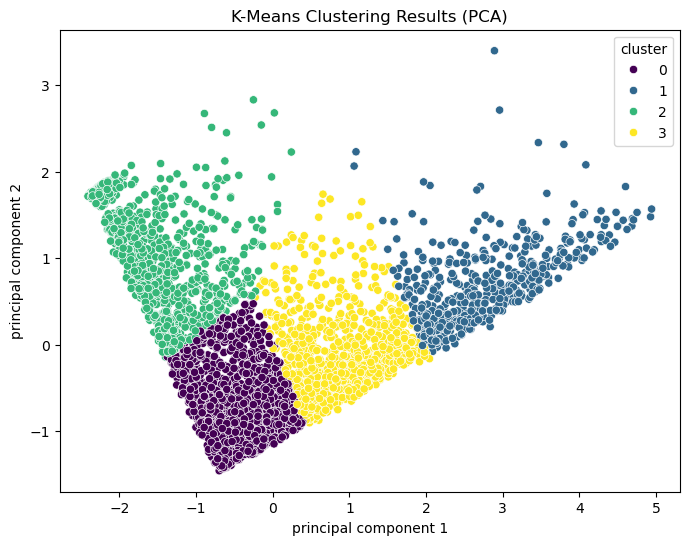

In [95]:
labels_non_outliers_df, kmeans_non_outliers_df = perform_kmeans_clustering(non_outliers_df, n_clusters=4)

Phân cụm rõ ràng ở khoảng n_cluster = 3 or 4

#### 3.2.2.3 Model Kmeans (With Log Data)

Silhouette Score: 0.3287144393420125
Calinski-Harabasz Score: 2816.928905401757
Davies-Bouldin Score: 1.0183932767221475
Dunn Index: 0.0032545142376569362


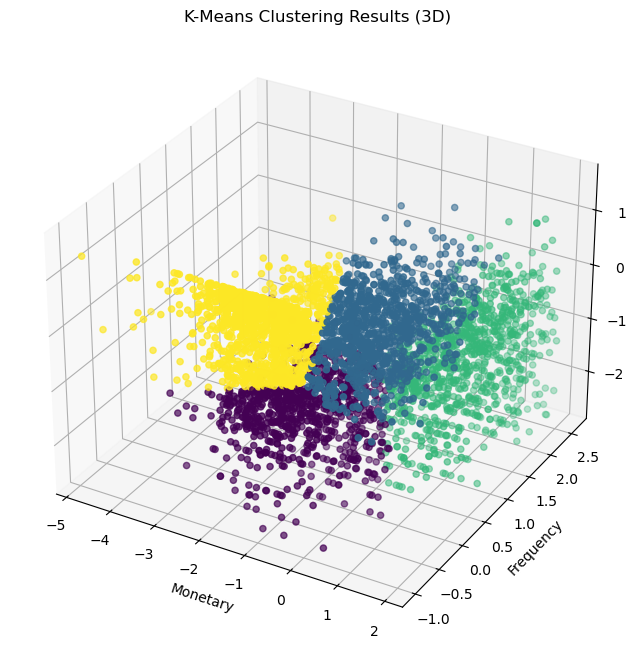

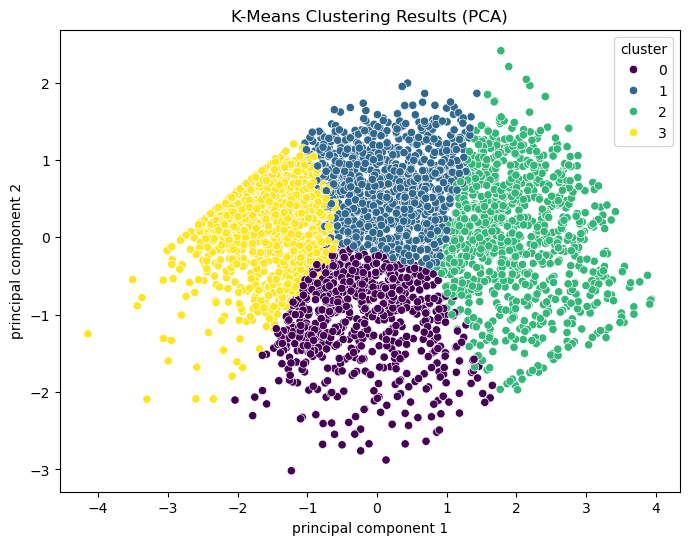

In [100]:
labels_2, kmeans_non_outliers_df_log = perform_kmeans_clustering(non_outliers_df_log, 4)

## 3.3 Model DBSCAN (With Outliers Data only)

### 3.3.1 Sử dụng KNN để biết param phù hợp nhất

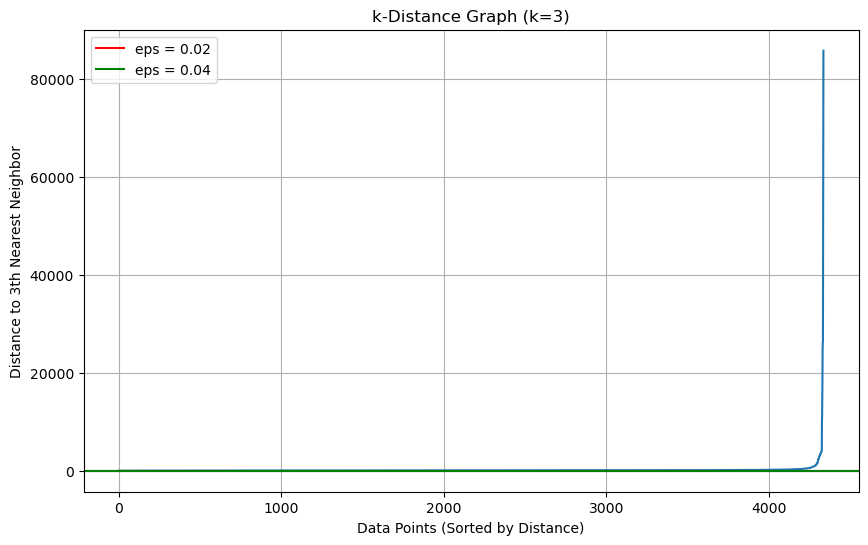

In [ ]:
def plot_k_distance(data, k):
    """
    Plots the k-distance graph to help determine the optimal eps for DBSCAN.

    Args:
        data: The input DataFrame or array for clustering.
        k: The number of neighbors to consider.
    """
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Sort distances
    distances = np.sort(distances[:, k-1], axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f'k-Distance Graph (k={k})')
    plt.xlabel('Data Points (Sorted by Distance)')
    plt.ylabel(f'Distance to {k}th Nearest Neighbor')
    plt.grid(True)

    # Add vertical lines at y=0.02 and y=0.1
    plt.axhline(y=0.02, color='r', linestyle='-', label='eps = 0.02')
    plt.axhline(y=0.04, color='g', linestyle='-', label='eps = 0.04')
    plt.legend()

    plt.show()

# Example usage (replace non_outliers_df_log with your data and choose a suitable k)
# A common starting point for k is 2 * number of dimensions, or simply a small value like 5
plot_k_distance(rfm, k=3)

### 3.3.2 Model DBSCAN

Number of clusters: 21
Number of noise points: 3501
Silhouette Score (excluding noise): 0.48472140922731305
Calinski-Harabasz Score (excluding noise): 6755.0143389542445
Davies-Bouldin Score (excluding noise): 0.5032200639002994


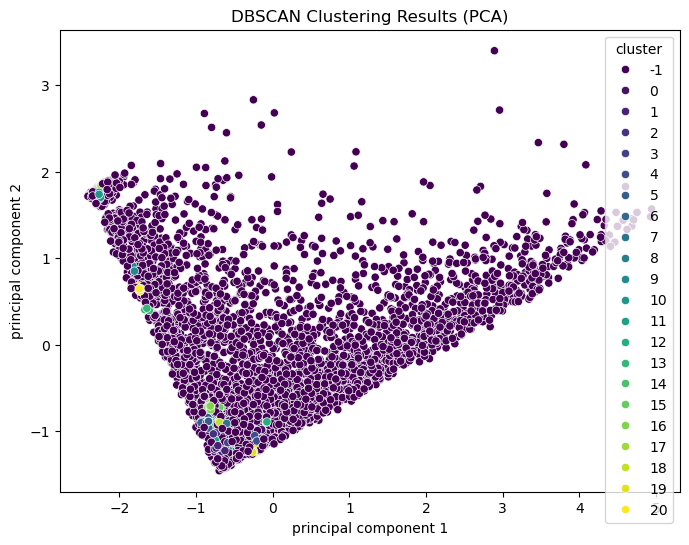

In [101]:
def perform_dbscan_clustering(data, eps, min_samples):
    """
    Performs DBSCAN clustering, evaluates the model, and visualizes the results.

    Args:
        data: The input DataFrame or array for clustering.
        eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        None (prints evaluation scores and plots the visualization).
    """
    # Build DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    # Evaluate the model
    # Note: Silhouette, Calinski-Harabasz, and Davies-Bouldin scores are not suitable for models with noise points (label -1)
    # We can calculate these scores on the data excluding the noise points.
    # However, for a more comprehensive evaluation, consider metrics like V-measure or Adjusted Rand Index if ground truth labels are available.

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")

    if n_clusters > 1:
        # Exclude noise points for evaluation metrics that require at least two clusters
        core_samples_mask = np.zeros_like(labels, dtype=bool)
        core_samples_mask[dbscan.core_sample_indices_] = True
        non_noise_indices = labels != -1

        if np.sum(non_noise_indices) > 1:
            silhouette = silhouette_score(data[non_noise_indices], labels[non_noise_indices])
            calinski = calinski_harabasz_score(data[non_noise_indices], labels[non_noise_indices])
            davies = davies_bouldin_score(data[non_noise_indices], labels[non_noise_indices])

            print(f"Silhouette Score (excluding noise): {silhouette}")
            print(f"Calinski-Harabasz Score (excluding noise): {calinski}")
            print(f"Davies-Bouldin Score (excluding noise): {davies}")
        else:
            print("Cannot compute evaluation scores: Not enough non-noise points for evaluation.")
    else:
        print("Cannot compute evaluation scores: Only one cluster or all points are noise.")


    # Visualize the clusters using PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    pca_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
    pca_df['cluster'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=pca_df, palette='viridis', legend='full')
    plt.title('DBSCAN Clustering Results (PCA)')
    plt.show()
    return labels, dbscan

# Example usage (replace non_outliers_df_log with your data)
# You might need to adjust min_samples based on your data
labels_dbscan, dbscan = perform_dbscan_clustering(non_outliers_df, eps=0.04, min_samples=10)




## 3.4. Save Model


In [102]:
def save_model(model, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(model, file)
        print(f"Model successfully saved to {filepath}")

# Save the KMeans model
save_model(kmeans_rfm, 'kmeans_model1.pkl')
save_model(kmeans_non_outliers_df, 'kmeans_model_non_outtliers.pkl')
save_model(kmeans_non_outliers_df_log, 'kmeans_model3.pkl')
save_model(dbscan, 'dbscan_model1.pkl')

Model successfully saved to kmeans_model1.pkl
Model successfully saved to kmeans_model_non_outtliers.pkl
Model successfully saved to kmeans_model3.pkl
Model successfully saved to dbscan_model1.pkl


## => Chọn Model Kmeans 3.2.2.2 làm phân tích

# 4. Outliers Analysis

## 4.1. Đưa labels của Cluster vào non_outliers_df

In [72]:
non_outliers_data['Cluster'] = labels_non_outliers_df
non_outliers_data = non_outliers_data.sort_values(by = 'CustomerID')
non_outliers_data

CustomerID  Recency  Frequency  Monetary  Cluster
2        12348.0       75          4   1797.24        3
3        12349.0       19          1   1757.55        3
4        12350.0      310          1    334.40        2
5        12352.0       36          8   2506.04        1
6        12353.0      204          1     89.00        2
...          ...      ...        ...       ...      ...
4332     18278.0       74          1    173.90        0
4333     18280.0      278          1    180.60        2
4334     18281.0      181          1     80.82        2
4335     18282.0        8          2    178.05        0
4337     18287.0       43          3   1837.28        3

[3864 rows x 5 columns]

## 4.2 Function để biểu diễn RFM cluster dưới dạng 2d và 3d 

2d để nhìn sự trồng lấn

3d để thấy tính rõ ràng 

In [73]:
def plot_rfm_clusters_2d(data):
    plt.figure(figsize=(10, 6))

    colors = ['red', 'blue', 'green', 'yellow', 'purple']

    for cluster in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster]
        plt.scatter(cluster_data['Recency'],
                    cluster_data['Frequency'],
                    c=colors[cluster],
                    label=f'Cluster {cluster}',
                    alpha=0.6)

    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    plt.title('Customer Segments in 2D RFM Space')
    plt.legend()
    plt.show()

def plot_rfm_clusters_3d(data):
    # Create 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create color map for clusters
    colors = ['red', 'blue', 'green', 'yellow','purple']

    # Plot each cluster
    for cluster in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster]
        ax.scatter(cluster_data['Monetary'],
                cluster_data['Frequency'],
                cluster_data['Recency'],
                c=colors[cluster],
                label=f'Cluster {cluster}',
                alpha=0.6)

    # Customize the plot
    ax.set_xlabel('Monetary')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Recency')
    ax.set_title('Customer Segments in 3D RFM Space')
    plt.legend()
    plt.show()

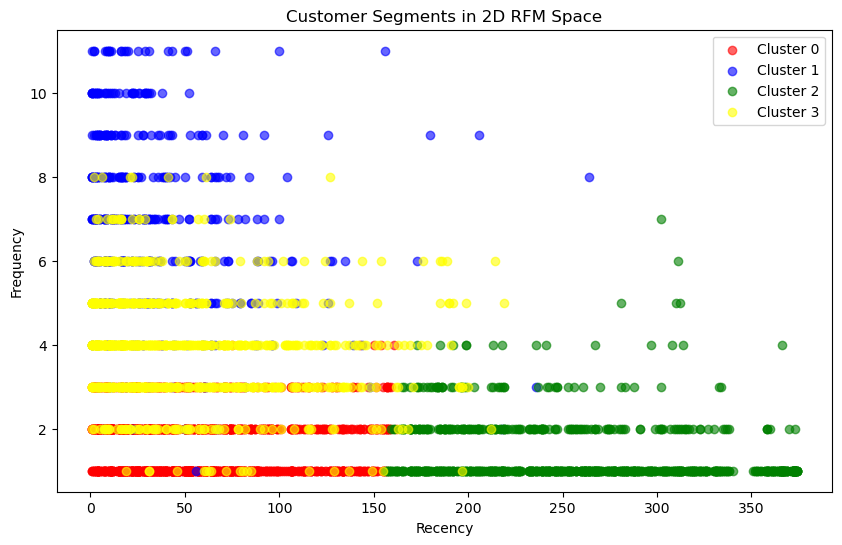

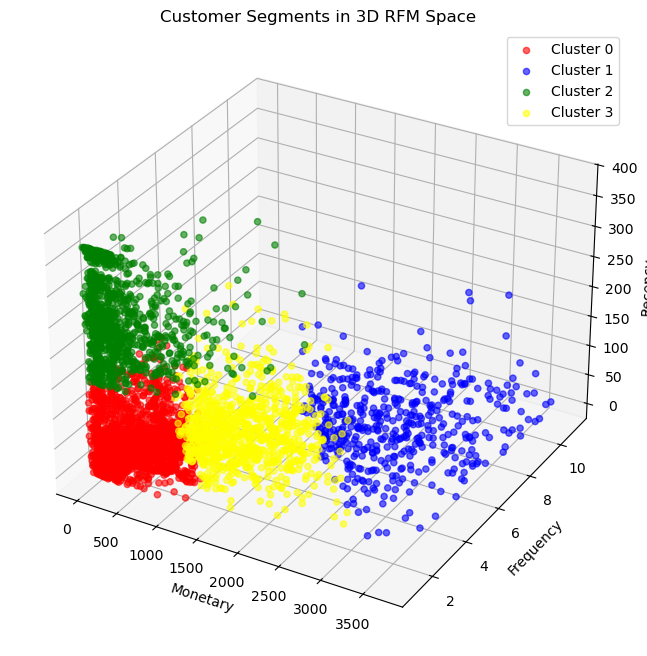

In [74]:
plot_rfm_clusters_2d(non_outliers_data)
plot_rfm_clusters_3d(non_outliers_data)

## 4.3. Tạo bảng dựa trên outliers vừa xóa đi và ghép nó vào bảng non_outliers_df

In [80]:
overlap_index = m_outliers.index.intersection(f_outliers.index)

m_o_outliers = m_outliers.drop(overlap_index)
f_o_outliers = f_outliers.drop(overlap_index)
mf_o_outliers = m_outliers.loc[overlap_index]

In [81]:
m_o_outliers['Cluster'] =  -3
f_o_outliers['Cluster'] = -2
mf_o_outliers['Cluster'] = -1

In [82]:
outliers_data = pd.concat([m_o_outliers, f_o_outliers, mf_o_outliers])
outliers_data

CustomerID  Recency  Frequency  Monetary  Cluster
0        12346.0      326          1  77183.60       -3
1        12347.0        2          7   4310.00       -3
10       12357.0       33          1   6207.67       -3
12       12359.0       58          4   6372.58       -3
15       12362.0        3         10   5226.23       -3
...          ...      ...        ...       ...      ...
4252     18172.0       15         20   7561.68       -1
4272     18198.0        4         17   5425.56       -1
4291     18223.0        5         14   6484.54       -1
4293     18225.0        3         12   5509.12       -1
4297     18229.0       12         20   7276.90       -1

[474 rows x 5 columns]

In [83]:
rfm_non_outliers = pd.concat([non_outliers_data, outliers_data])
rfm_non_outliers

CustomerID  Recency  Frequency  Monetary  Cluster
2        12348.0       75          4   1797.24        3
3        12349.0       19          1   1757.55        3
4        12350.0      310          1    334.40        2
5        12352.0       36          8   2506.04        1
6        12353.0      204          1     89.00        2
...          ...      ...        ...       ...      ...
4252     18172.0       15         20   7561.68       -1
4272     18198.0        4         17   5425.56       -1
4291     18223.0        5         14   6484.54       -1
4293     18225.0        3         12   5509.12       -1
4297     18229.0       12         20   7276.90       -1

[4338 rows x 5 columns]

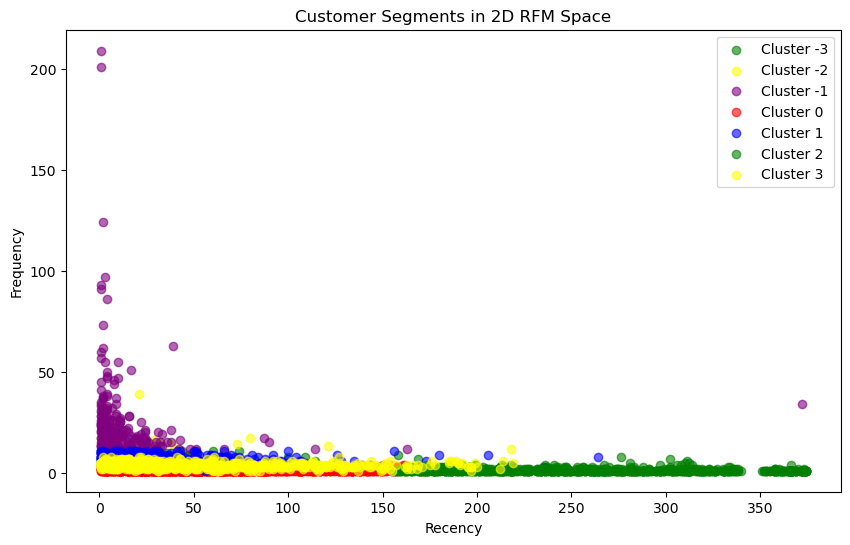

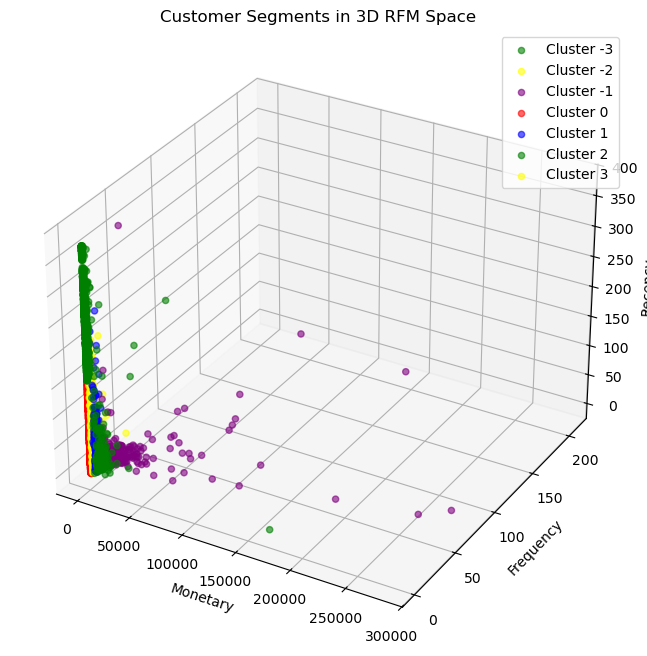

In [84]:
plot_rfm_clusters_2d(rfm_non_outliers)

plot_rfm_clusters_3d(rfm_non_outliers)


## 4.4. Visualize all Cluster Labels


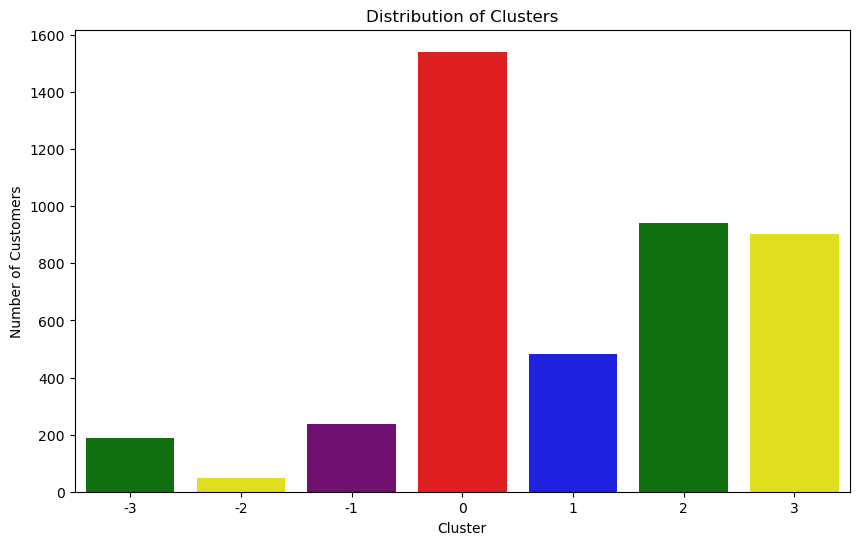

In [85]:
cluster_sizes = rfm_non_outliers['Cluster'].value_counts()
color1 = ['green', 'yellow', 'purple','red', 'blue', ]

plt.figure(figsize = (10,6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette = color1)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Add value labels on top of each bar
# for i, v in enumerate(cluster_sizes.values):
#     plt.text(i, v, str(v), ha='center', va='bottom')
# plt.show()

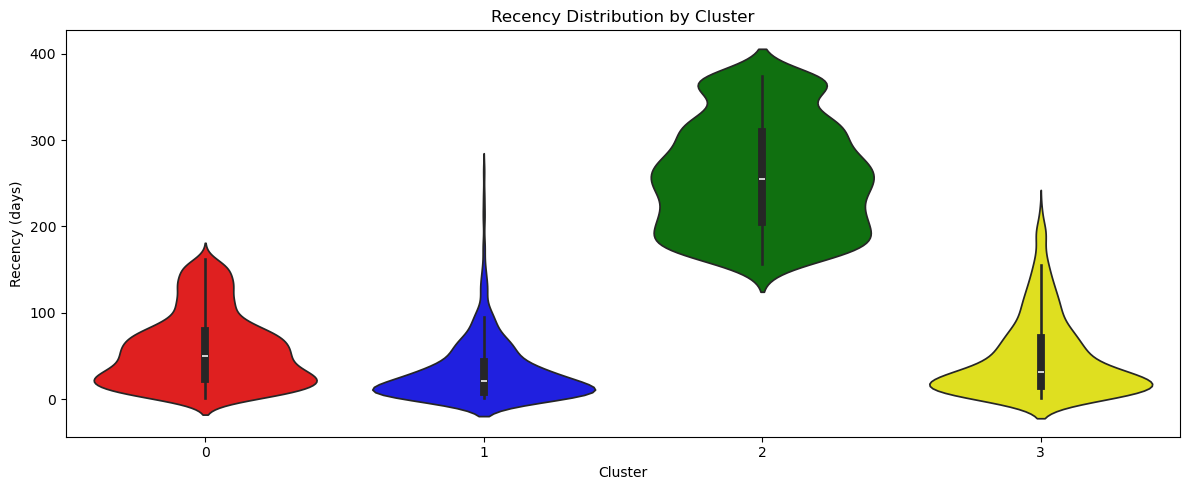

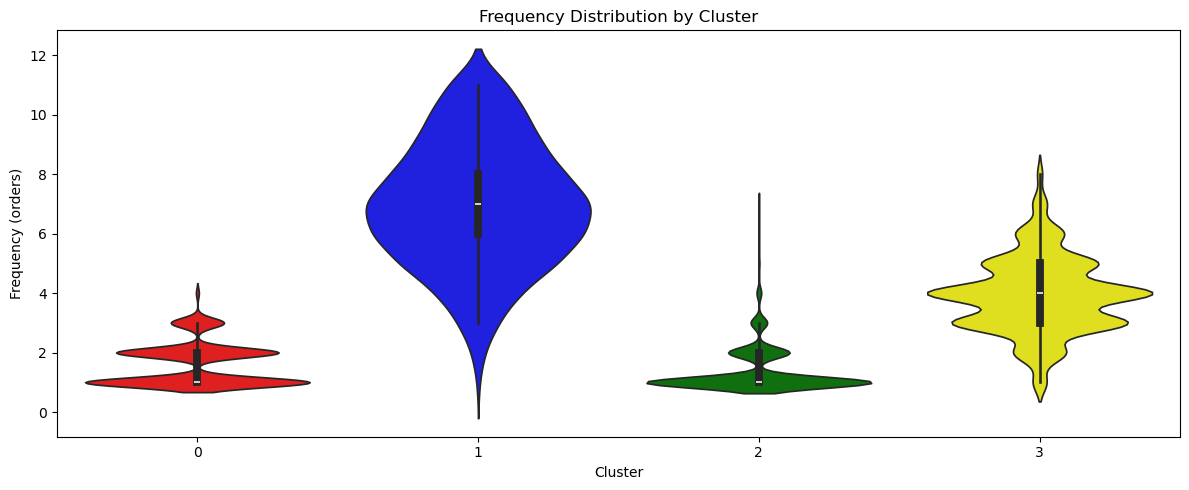

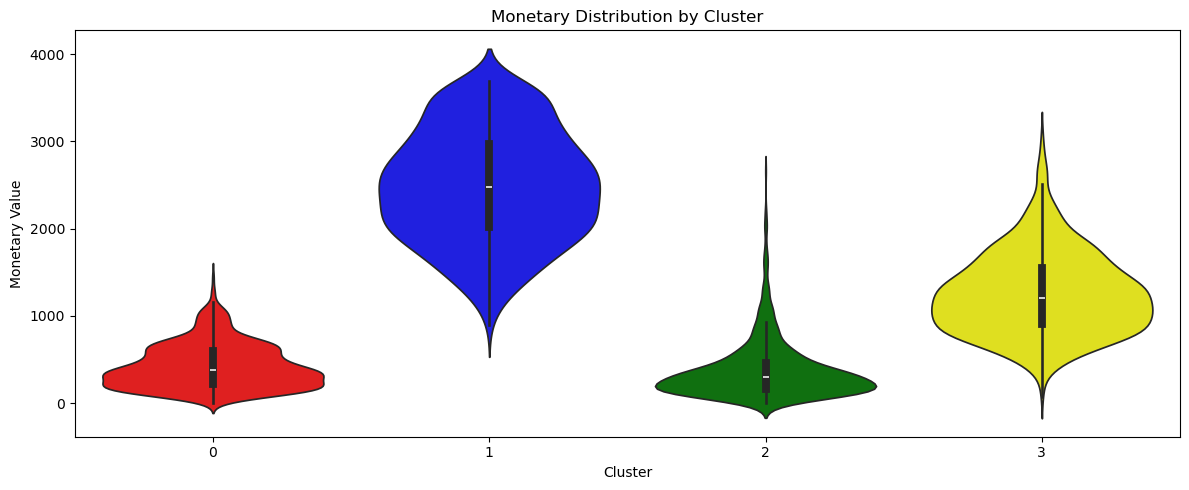

In [86]:
def plot_non_out_violin(data):
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

    # Plot Recency
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Recency', data=data, palette = ['red', 'blue', 'green', 'yellow','purple' ])
    plt.title('Recency Distribution by Cluster')
    plt.ylabel('Recency (days)')
    plt.tight_layout()
    plt.show()

    # Plot Frequency
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Frequency', data=data, palette = ['red', 'blue', 'green', 'yellow','purple' ])
    plt.title('Frequency Distribution by Cluster')
    plt.ylabel('Frequency (orders)')
    plt.tight_layout()
    plt.show()

    # Plot Monetary
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Monetary', data=data, palette = ['red', 'blue', 'green', 'yellow','purple' ])
    plt.title('Monetary Distribution by Cluster')
    plt.ylabel('Monetary Value')

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_non_out_violin(non_outliers_data)


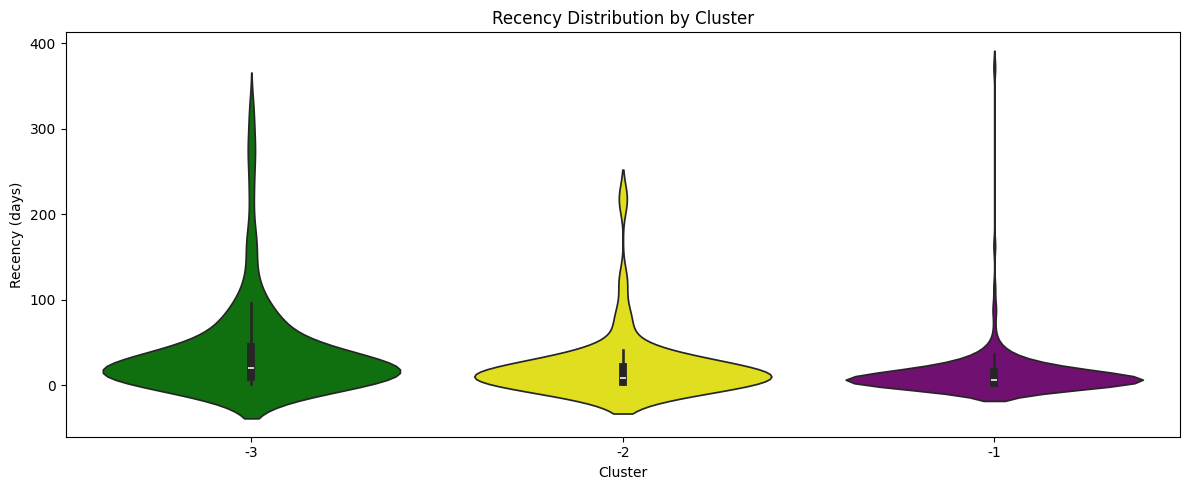

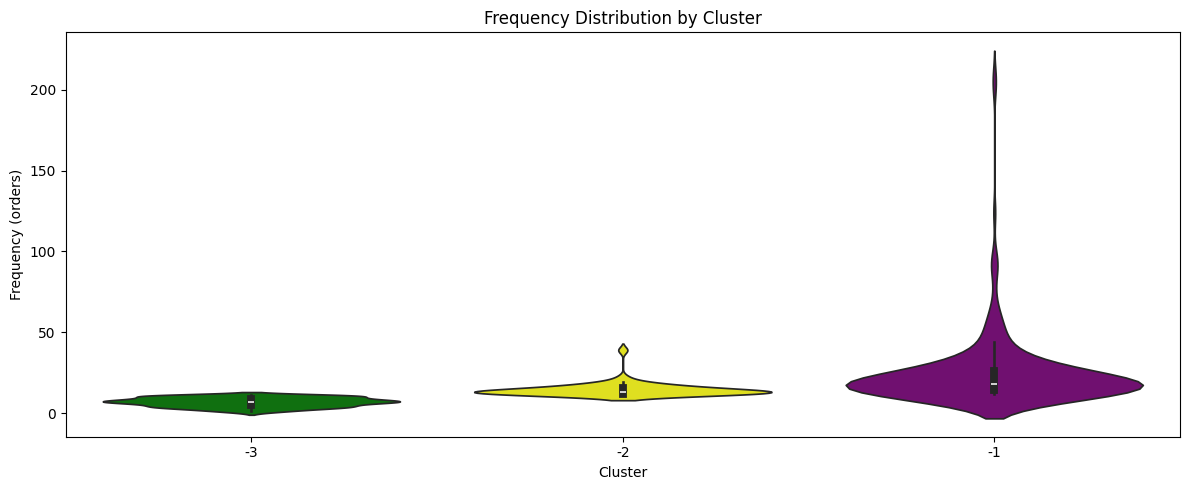

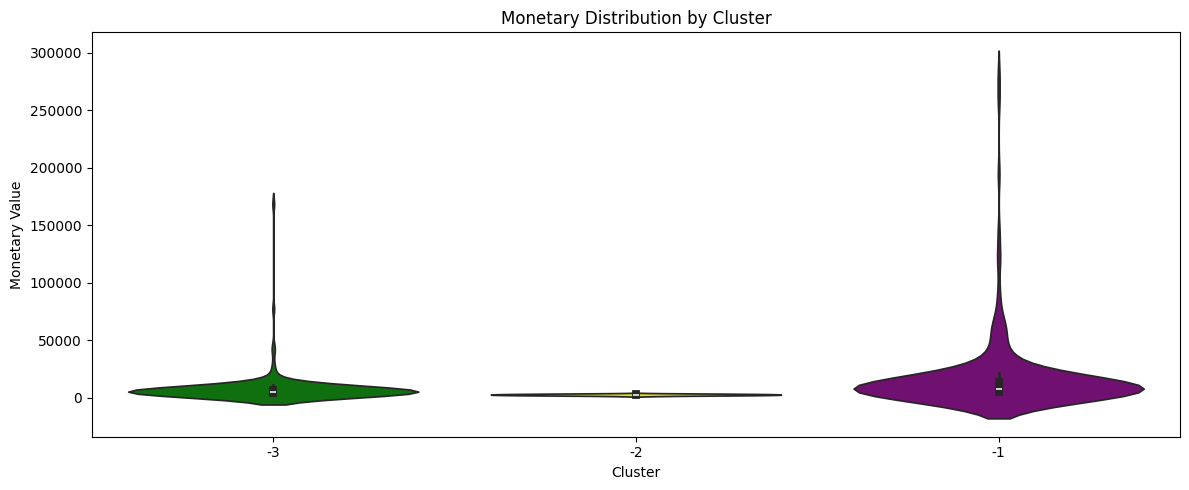

In [ ]:
def plot_non_out_violin(data):
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

    # Plot Recency
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Recency', data=data, palette = ['green', 'yellow', 'purple'])
    plt.title('Recency Distribution by Cluster')
    plt.ylabel('Recency (days)')
    plt.tight_layout()
    plt.show()

    # Plot Frequency
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Frequency', data=data, palette = ['green', 'yellow', 'purple' ])
    plt.title('Frequency Distribution by Cluster')
    plt.ylabel('Frequency (orders)')
    plt.tight_layout()
    plt.show()

    # Plot Monetary
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Monetary', data=data, palette = ['green', 'yellow', 'purple' ])
    plt.title('Monetary Distribution by Cluster')
    plt.ylabel('Monetary Value')

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_non_out_violin(outliers_data)


# 5. Phân nhóm các khách hàng này


## 5.1. Calculate mean and median for each cluster

In [88]:
cluster_summary_mean = rfm_non_outliers.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_summary_median = rfm_non_outliers.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].median()

print("Mean values for each cluster:")
display(cluster_summary_mean)

print("\nMedian values for each cluster:")
display(cluster_summary_median)

Mean values for each cluster:


Recency  Frequency      Monetary
Cluster                                     
-3        40.269841   6.857143   7535.036984
-2        21.510638  14.595745   2646.785957
-1        13.273109  24.605042  16888.991681
 0        56.924724   1.626217    426.745945
 1        32.244813   6.958506   2484.088280
 2       258.905319   1.373404    379.391234
 3        47.733629   3.932297   1256.085617


Median values for each cluster:


Recency  Frequency  Monetary
Cluster                              
-3          20.0        7.0  4939.990
-2           8.0       13.0  2622.570
-1           5.5       18.0  7318.000
 0          50.0        1.0   377.010
 1          21.0        7.0  2474.280
 2         255.0        1.0   298.295
 3          31.0        4.0  1201.060

In [89]:
print("Mean values for each cluster:")
display(cluster_summary_mean)

print("\nInterpretation of Mean values:")
print("Cluster -3 (Monetary Outliers): Moderate recency, Moderate frequency, Very high monetary value.")
print("Cluster -2 (Frequency Outliers): Low recency, Very high frequency, Moderate monetary value.")
print("Cluster -1 (Monetary and Frequency Outliers): Very low recency, Extremely high frequency, Extremely high monetary value.")
print("Cluster 0: High recency, Very low frequency, Very low monetary value.")
print("Cluster 1: Low recency, High frequency, High monetary value.")
print("Cluster 2: Very high recency, Very low frequency, Very low monetary value (Inactive/Churned).")
print("Cluster 3: Moderate recency, Moderate frequency, Moderate monetary value.")

print("\nMedian values for each cluster:")
display(cluster_summary_median)

print("\nInterpretation of Median values:")
print("Cluster -3 (Monetary Outliers): Moderate recency, Moderate frequency, High monetary value.")
print("Cluster -2 (Frequency Outliers): Low recency, High frequency, Moderate monetary value.")
print("Cluster -1 (Monetary and Frequency Outliers): Very low recency, High frequency, Very high monetary value.")
print("Cluster 0: Moderate recency, Very low frequency, Very low monetary value.")
print("Cluster 1: Low recency, High frequency, High monetary value.")
print("Cluster 2: High recency, Very low frequency, Very low monetary value (Inactive/Churned).")
print("Cluster 3: Moderate recency, Moderate frequency, Moderate monetary value.")

Mean values for each cluster:


Recency  Frequency      Monetary
Cluster                                     
-3        40.269841   6.857143   7535.036984
-2        21.510638  14.595745   2646.785957
-1        13.273109  24.605042  16888.991681
 0        56.924724   1.626217    426.745945
 1        32.244813   6.958506   2484.088280
 2       258.905319   1.373404    379.391234
 3        47.733629   3.932297   1256.085617


Interpretation of Mean values:
Cluster -3 (Monetary Outliers): Moderate recency, Moderate frequency, Very high monetary value.
Cluster -2 (Frequency Outliers): Low recency, Very high frequency, Moderate monetary value.
Cluster -1 (Monetary and Frequency Outliers): Very low recency, Extremely high frequency, Extremely high monetary value.
Cluster 0: High recency, Very low frequency, Very low monetary value.
Cluster 1: Low recency, High frequency, High monetary value.
Cluster 2: Very high recency, Very low frequency, Very low monetary value (Inactive/Churned).
Cluster 3: Moderate recency, Moderate frequency, Moderate monetary value.

Median values for each cluster:


Recency  Frequency  Monetary
Cluster                              
-3          20.0        7.0  4939.990
-2           8.0       13.0  2622.570
-1           5.5       18.0  7318.000
 0          50.0        1.0   377.010
 1          21.0        7.0  2474.280
 2         255.0        1.0   298.295
 3          31.0        4.0  1201.060


Interpretation of Median values:
Cluster -3 (Monetary Outliers): Moderate recency, Moderate frequency, High monetary value.
Cluster -2 (Frequency Outliers): Low recency, High frequency, Moderate monetary value.
Cluster -1 (Monetary and Frequency Outliers): Very low recency, High frequency, Very high monetary value.
Cluster 0: Moderate recency, Very low frequency, Very low monetary value.
Cluster 1: Low recency, High frequency, High monetary value.
Cluster 2: High recency, Very low frequency, Very low monetary value (Inactive/Churned).
Cluster 3: Moderate recency, Moderate frequency, Moderate monetary value.


## 5.2. Assign meaningful names to clusters

In [90]:
cluster_names = {
    -1: 'Valuable Customers (Outliers)',
    -2: 'Frequent Buyers (Outliers)',
    -3: 'High-Spending Buyers (Outliers)',
    0: 'New/Single Purchase Customers',
    1: 'Engaged Customers',
    2: 'At Risk Customers',
    3: 'Moderate Engagement Customers'
}

rfm_non_outliers['Segment'] = rfm_non_outliers['Cluster'].map(cluster_names)

display(rfm_non_outliers.head())

CustomerID  Recency  Frequency  Monetary  Cluster  \
2     12348.0       75          4   1797.24        3   
3     12349.0       19          1   1757.55        3   
4     12350.0      310          1    334.40        2   
5     12352.0       36          8   2506.04        1   
6     12353.0      204          1     89.00        2   

                         Segment  
2  Moderate Engagement Customers  
3  Moderate Engagement Customers  
4              At Risk Customers  
5              Engaged Customers  
6              At Risk Customers

In [ ]:


# Calculate mean RFM values for each segment
segment_rfm_mean = rfm_non_outliers.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Calculate segment counts
segment_counts = rfm_non_outliers['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']


# Merge segment counts with mean RFM values
segment_data = pd.merge(segment_counts, segment_rfm_mean, on='Segment')

# Create the treemap with additional information
fig = px.treemap(segment_data,
                 path=['Segment'],
                 values='Count',
                 color='Monetary',  # Color the segments by average Monetary value
                 hover_data=['Recency', 'Frequency', 'Monetary'],  # Show RFM values on hover
                 title='Distribution of Customers Across Segments with Average RFM Values')
fig.show()

## 5.3. Customer Segmentation

In [ ]:

segment_characteristics = {
    'Nhóm': [
        'Cluster -1 (Monetary + Frequency outliers)',
        'Cluster -2 (Frequency outliers)',
        'Cluster -3 (Monetary outliers)',
        'Cluster 0',
        'Cluster 1',
        'Cluster 2',
        'Cluster 3'
    ],
    'Đặc điểm chính': [
        'Recency thấp, Frequency rất cao, Monetary rất cao',
        'Recency thấp, Frequency cao, Monetary vừa',
        'Recency thấp-vừa, Frequency trung bình, Monetary rất cao',
        'Recency thấp-vừa, Frequency thấp, Monetary thấp',
        'Recency vừa, Frequency vừa, Monetary vừa',
        'Recency cao, Frequency thấp, Monetary thấp',
        'Recency vừa, Frequency trung bình, Monetary nhỉnh hơn nhóm yếu'
    ],
    'Điểm khác biệt nổi bật': [
        'VIP số 1 (Champions) - Khách hàng giá trị nhất, mua sắm thường xuyên và chi tiêu lớn.',
        'VIP mua thường xuyên nhưng không chi tiêu lớn - Tần suất mua cao nhưng giá trị mỗi lần mua không bằng nhóm VIP số 1.',
        'VIP mua ít nhưng mỗi lần rất lớn - Chi tiêu cao nhưng tần suất mua không thường xuyên.',
        'Khách mới hoặc mua ít, gần đây - Nhóm này có thể đang trong giai đoạn đầu của vòng đời khách hàng hoặc chỉ mua một lần.',
        'Khách khá ổn định, có tương tác trung bình - Nhóm này có mức độ tương tác và giá trị trung bình.',
        'Khách sắp rời bỏ, từng mua nhưng không quay lại lâu - Đây là nhóm có nguy cơ cao không tiếp tục mua hàng.',
        'Nhóm trung gian - Không quá yếu như Cluster 0, 2 nhưng cũng chưa ổn định như Cluster 1; thường là khách cần nurturing để nâng giá trị lâu dài'
    ]
}

# Create a pandas DataFrame from the dictionary
segment_summary_table_qualitative = pd.DataFrame(segment_characteristics)

# Display the table
display(segment_summary_table_qualitative)

Nhóm  \
0  Cluster -1 (Monetary + Frequency outliers)   
1             Cluster -2 (Frequency outliers)   
2              Cluster -3 (Monetary outliers)   
3                                   Cluster 0   
4                                   Cluster 1   
5                                   Cluster 2   
6                                   Cluster 3   

                                      Đặc điểm chính  \
0  Recency thấp, Frequency rất cao, Monetary rất cao   
1          Recency thấp, Frequency cao, Monetary vừa   
2  Recency thấp-vừa, Frequency trung bình, Moneta...   
3    Recency thấp-vừa, Frequency thấp, Monetary thấp   
4           Recency vừa, Frequency vừa, Monetary vừa   
5         Recency cao, Frequency thấp, Monetary thấp   
6  Recency vừa, Frequency trung bình, Monetary nh...   

                              Điểm khác biệt nổi bật  
0  VIP số 1 (Champions) - Khách hàng giá trị nhất...  
1  VIP mua thường xuyên nhưng không chi tiêu lớn ...  
2  VIP mua ít nhưng mỗi lần rất lớn - Chi tiêu ca...  
3  Khách mới hoặc mua ít, gần đây - Nhóm này có t...  
4  Khách khá ổn định, có tương tác trung bình - N...  
5  Khách sắp rời bỏ, từng mua nhưng không quay lạ...  
6  Nhóm trung gian - Không quá yếu như Cluster 0,...

# 6. Cluster Analysis & Profiling

## 6.1. Phân tích đặc điểm nhân khẩu học

In [ ]:
df_with_clusters = pd.merge(df, rfm_non_outliers[['CustomerID', 'Cluster', 'Segment']], on='CustomerID', how='left')

# Group by Segment and Country and count customers
segment_country_distribution = df_with_clusters.groupby(['Segment', 'Country'])['CustomerID'].nunique().reset_index()
segment_country_distribution.columns = ['Segment', 'Country', 'CustomerCount']

# Calculate the total number of customers in each segment
total_customers_per_segment = segment_country_distribution.groupby('Segment')['CustomerCount'].sum().reset_index()
total_customers_per_segment.columns = ['Segment', 'TotalCustomers']

# Merge to calculate the percentage
segment_country_distribution = pd.merge(segment_country_distribution, total_customers_per_segment, on='Segment')
segment_country_distribution['Percentage'] = (segment_country_distribution['CustomerCount'] / segment_country_distribution['TotalCustomers']) * 100

# Display the distribution for each segment
for segment in segment_country_distribution['Segment'].unique():
    print(f"Distribution for {segment}:")
    display(segment_country_distribution[segment_country_distribution['Segment'] == segment].sort_values(by='Percentage', ascending=False).head().drop(columns=['Segment']))
    print("\n")

Distribution for At Risk Customers:


Country  CustomerCount  TotalCustomers  Percentage
25  United Kingdom            856             940   91.063830
9           France             18             940    1.914894
10         Germany             13             940    1.382979
18        Portugal              6             940    0.638298
3          Belgium              5             940    0.531915



Distribution for Engaged Customers:


Country  CustomerCount  TotalCustomers  Percentage
43  United Kingdom            440             486   90.534979
35         Germany              9             486    1.851852
34          France              9             486    1.851852
29         Belgium              5             486    1.028807
42     Switzerland              3             486    0.617284



Distribution for Frequent Buyers (Outliers):


Country  CustomerCount  TotalCustomers  Percentage
45  United Kingdom             46              47    97.87234
44         Belgium              1              47     2.12766



Distribution for High-Spending Buyers (Outliers):


Country  CustomerCount  TotalCustomers  Percentage
64  United Kingdom            134             190   70.526316
54         Germany             14             190    7.368421
53          France             10             190    5.263158
63     Switzerland              5             190    2.631579
62           Spain              5             190    2.631579



Distribution for Moderate Engagement Customers:


Country  CustomerCount  TotalCustomers  Percentage
85  United Kingdom            814             903   90.143965
73         Germany             19             903    2.104097
72          France             18             903    1.993355
67         Belgium              8             903    0.885936
81           Spain              6             903    0.664452



Distribution for New/Single Purchase Customers:


Country  CustomerCount  TotalCustomers  Percentage
112  United Kingdom           1415            1541   91.823491
96          Germany             31            1541    2.011681
95           France             25            1541    1.622323
107           Spain             11            1541    0.713822
105        Portugal              6            1541    0.389358



Distribution for Valuable Customers (Outliers):


Country  CustomerCount  TotalCustomers  Percentage
123  United Kingdom            215             239   89.958159
118         Germany              8             239    3.347280
117          France              7             239    2.928870
114       Australia              2             239    0.836820
116            EIRE              2             239    0.836820

Có thể thấy phần lớn khách hàng của các cụm đều đến từ UK (do trong dữ liệu gốc hơn 90% khách đều ở UK, nên sẽ phân tích theo hướng phân biệt khách thuộc UK và khách ngoài UK)

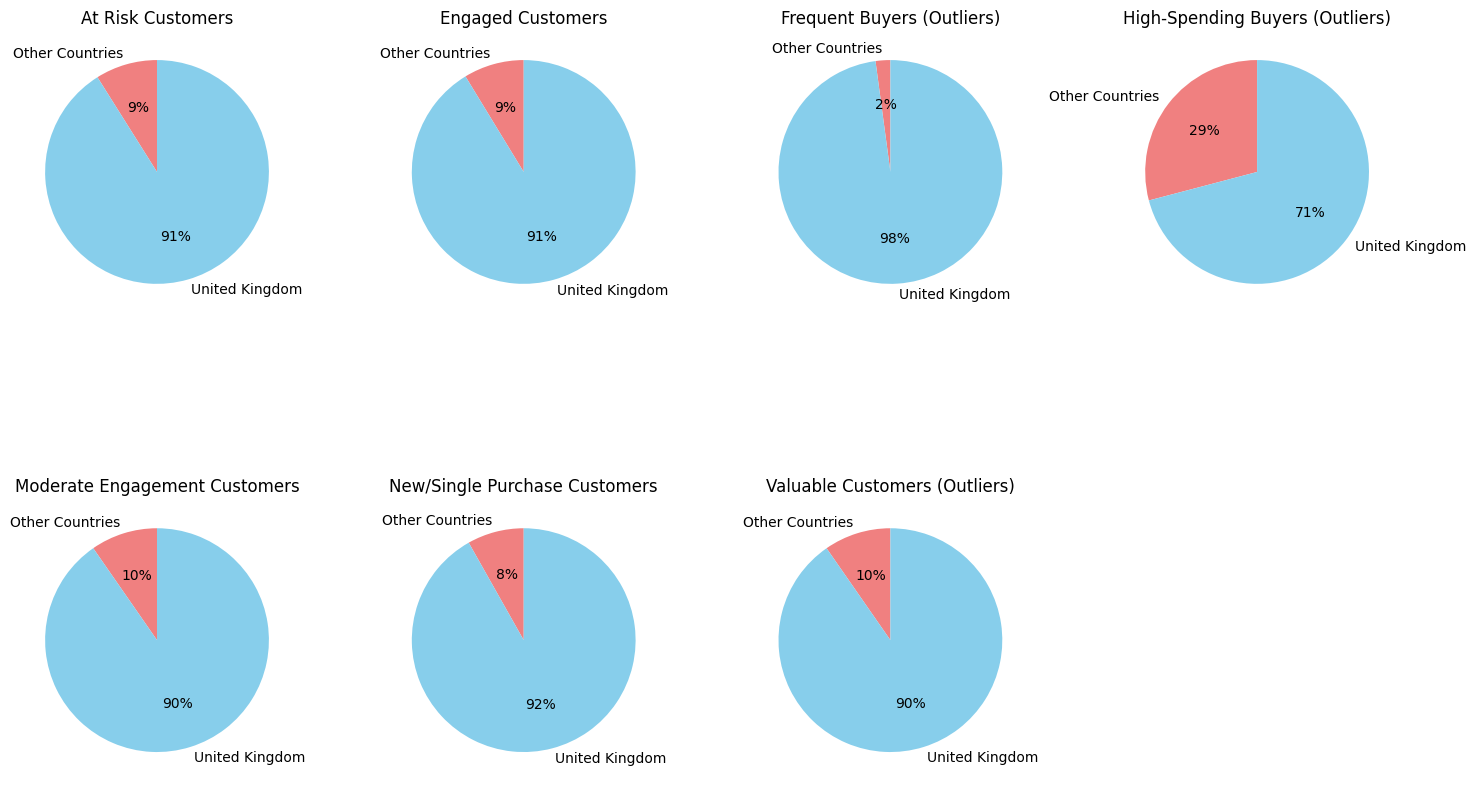

In [ ]:
# Categorize countries into UK and Non-UK
df_with_clusters['Country_Category'] = df_with_clusters['Country'].apply(lambda x: 'United Kingdom' if x == 'United Kingdom' else 'Other Countries')

# Group by Segment and Country_Category and count customers
uk_nonuk_distribution = df_with_clusters.groupby(['Segment', 'Country_Category'])['CustomerID'].nunique().reset_index()
uk_nonuk_distribution.columns = ['Segment', 'Country_Category', 'CustomerCount']

# Plotting pie charts for each segment
segments = sorted(uk_nonuk_distribution['Segment'].unique())
num_segments = len(segments)

# Determine the grid layout (3 then 4)
nrows = 2 if num_segments > 3 else 1
ncols1 = 3 if num_segments > 3 else num_segments
ncols2 = num_segments - ncols1 if num_segments > 3 else 0
fig, axes = plt.subplots(nrows, max(ncols1, ncols2) if num_segments > 3 else ncols1, figsize=(15, nrows * 5))
axes = axes.flatten() if nrows > 1 else [axes] # Ensure axes is always an iterable

# Define consistent colors for UK and Other Countries
colors = {'United Kingdom': 'skyblue', 'Other Countries': 'lightcoral'}

for i, segment in enumerate(segments):
    ax = axes[i]
    segment_data = uk_nonuk_distribution[uk_nonuk_distribution['Segment'] == segment]

    # Ensure both categories are present even if count is 0 for a segment
    # This is important for consistent pie chart structure and colors
    for category in colors.keys():
        if category not in segment_data['Country_Category'].values:
            segment_data = segment_data.append({'Segment': segment, 'Country_Category': category, 'CustomerCount': 0}, ignore_index=True)

    # Sort by category name for consistent color mapping order
    segment_data = segment_data.sort_values(by='Country_Category')


    # Plot pie chart with consistent colors
    ax.pie(segment_data['CustomerCount'],
           labels=segment_data['Country_Category'],
           autopct='%1.0f%%',
           startangle=90,
           colors=[colors[cat] for cat in segment_data['Country_Category']])
    ax.set_title(f'{segment}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 6.2. Phân tích hành vi mua sắm

Phân tích hành vi mua sắm qua các time-base features, sau đó phân tích các sản phẩm phổ biến và thời điểm mua hàng cho từng cụm bằng cách nhóm và tổng hợp.

In [ ]:
# Merge cluster information with the original dataframe 'df' again to ensure 'IsCancelled' is available
df_with_clusters = pd.merge(df, rfm_non_outliers[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Identify cancelled orders in the original dataframe and add as a column
df_with_clusters['IsCancelled'] = (df_with_clusters['Quantity'] < 0) | (df_with_clusters['InvoiceNo'].astype(str).str.startswith('C'))


# 1. Extract time-based features
df_with_clusters['Hour'] = df_with_clusters['InvoiceDate'].dt.hour
df_with_clusters['DayOfWeek'] = df_with_clusters['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
df_with_clusters['Month'] = df_with_clusters['InvoiceDate'].dt.month

In [ ]:
# 2. For each cluster, determine the most frequent product descriptions.
# Filter out cancelled orders before analyzing popular products
df_purchases = df_with_clusters[~df_with_clusters['IsCancelled']].copy()

popular_products_per_cluster = df_purchases.groupby(['Cluster', 'Description']).size().reset_index(name='Count')

# Display the top N descriptions for each cluster in separate tables
top_n = 5
print(f"Top {top_n} Popular Products per Cluster:")
for cluster in sorted(popular_products_per_cluster['Cluster'].unique()):
    # Use segment names in titles
    segment_name = cluster_names.get(cluster, f'Cluster {int(cluster)}')
    print(f"\n{segment_name}:")
    cluster_top_products = popular_products_per_cluster[popular_products_per_cluster['Cluster'] == cluster].nlargest(top_n, 'Count')
    display(cluster_top_products)

Top 5 Popular Products per Cluster:

High-Spending Buyers (Outliers):


Cluster                         Description  Count
2065     -3.0            REGENCY CAKESTAND 3 TIER    198
1318     -3.0             JUMBO BAG RED RETROSPOT    197
1942     -3.0                             POSTAGE    192
1447     -3.0             LUNCH BAG RED RETROSPOT    177
2809     -3.0  WHITE HANGING HEART T-LIGHT HOLDER    167


Frequent Buyers (Outliers):


Cluster                         Description  Count
5010     -2.0  WHITE HANGING HEART T-LIGHT HOLDER    100
3901     -2.0             JUMBO BAG RED RETROSPOT     73
4399     -2.0    RED HANGING HEART T-LIGHT HOLDER     66
3996     -2.0             LUNCH BAG RED RETROSPOT     61
4415     -2.0         RED RETROSPOT CHARLOTTE BAG     59


Valuable Customers (Outliers):


Cluster                         Description  Count
6665     -1.0             JUMBO BAG RED RETROSPOT    640
8418     -1.0  WHITE HANGING HEART T-LIGHT HOLDER    543
7557     -1.0            REGENCY CAKESTAND 3 TIER    537
6824     -1.0             LUNCH BAG RED RETROSPOT    493
7195     -1.0                       PARTY BUNTING    449


New/Single Purchase Customers:


Cluster                         Description  Count
11655      0.0  WHITE HANGING HEART T-LIGHT HOLDER    231
10900      0.0        REX CASH+CARRY JUMBO SHOPPER    225
8763       0.0       ASSORTED COLOUR BIRD ORNAMENT    201
10495      0.0     PAPER CHAIN KIT 50'S CHRISTMAS     188
10855      0.0            REGENCY CAKESTAND 3 TIER    175


Engaged Customers:


Cluster                         Description  Count
14981      1.0  WHITE HANGING HEART T-LIGHT HOLDER    442
14150      1.0            REGENCY CAKESTAND 3 TIER    316
13300      1.0             JUMBO BAG RED RETROSPOT    278
13458      1.0             LUNCH BAG RED RETROSPOT    278
11988      1.0       ASSORTED COLOUR BIRD ORNAMENT    275


At Risk Customers:


Cluster                         Description  Count
17733      2.0  WHITE HANGING HEART T-LIGHT HOLDER    157
17093      2.0            REGENCY CAKESTAND 3 TIER    138
16792      2.0                       PARTY BUNTING    110
15292      2.0       ASSORTED COLOUR BIRD ORNAMENT     95
17131      2.0        REX CASH+CARRY JUMBO SHOPPER     93


Moderate Engagement Customers:


Cluster                         Description  Count
20997      3.0  WHITE HANGING HEART T-LIGHT HOLDER    388
20171      3.0            REGENCY CAKESTAND 3 TIER    326
18039      3.0       ASSORTED COLOUR BIRD ORNAMENT    316
19841      3.0                       PARTY BUNTING    249
19344      3.0             JUMBO BAG RED RETROSPOT    238

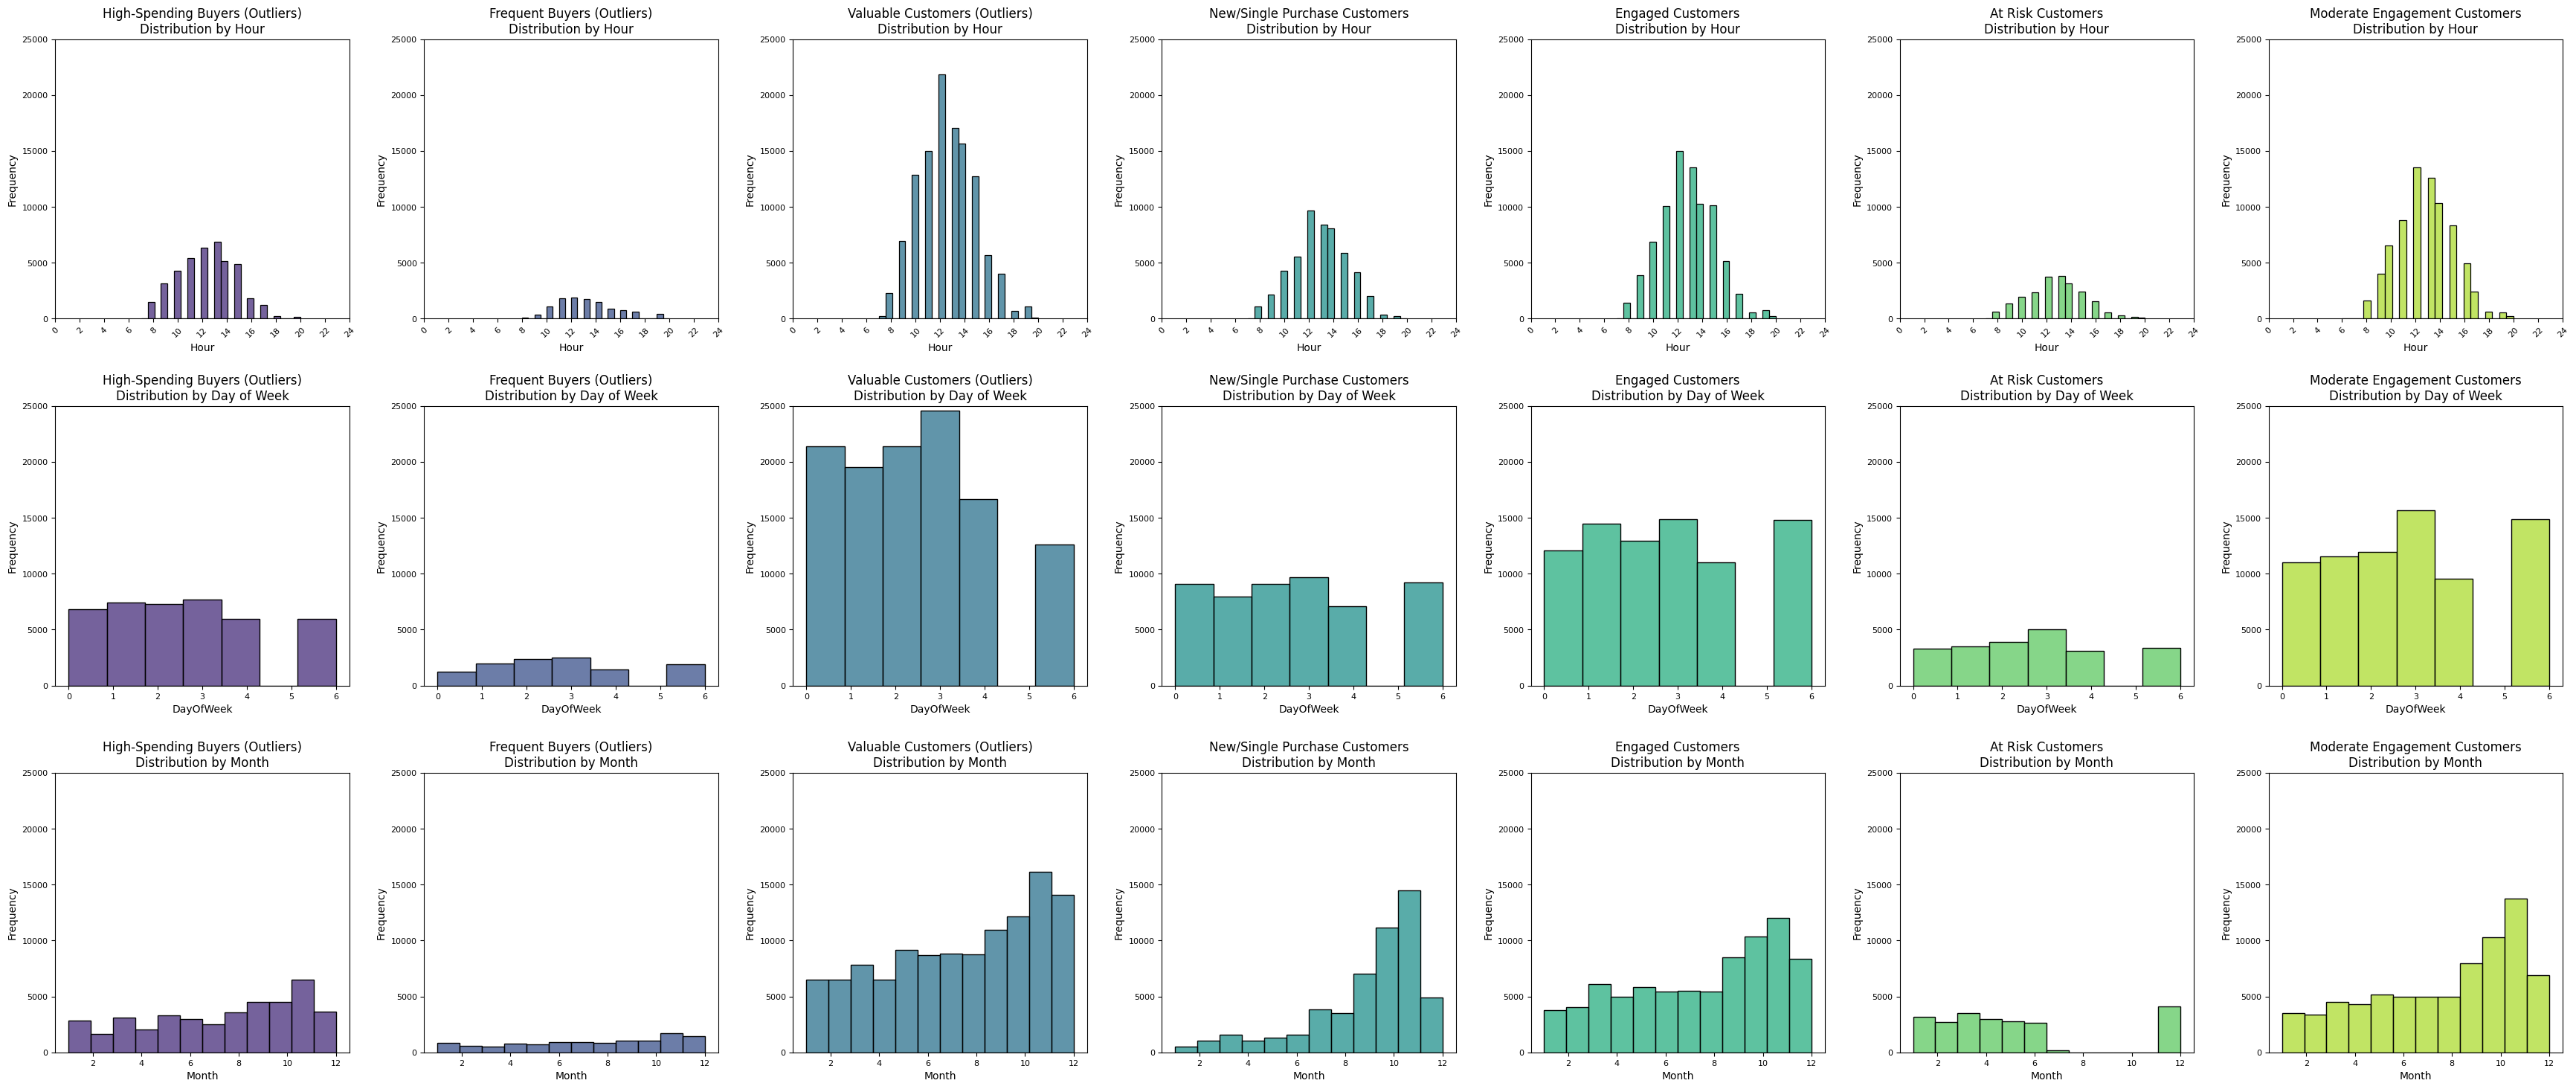

In [ ]:
# Get unique clusters for plotting, exclude NaN
clusters = sorted([c for c in df_purchases['Cluster'].unique() if pd.notna(c)])
num_clusters = len(clusters)

# Define the timing features
timing_features = ['Hour', 'DayOfWeek', 'Month']
timing_titles = ['Distribution by Hour', 'Distribution by Day of Week', 'Distribution by Month']
timing_bins = [24, 7, 12] # Number of bins for each feature

# Create a figure and axes for the grid of plots - Reverted to previous size
fig, axes = plt.subplots(len(timing_features), num_clusters, figsize=(num_clusters * 5, len(timing_features) * 5)) # Increased figure size


for i, feature in enumerate(timing_features):
    for j, cluster in enumerate(clusters):
        ax = axes[i, j]
        cluster_data = df_purchases[df_purchases['Cluster'] == cluster]

        sns.histplot(data=cluster_data, x=feature, bins=timing_bins[i], ax=ax, color=sns.color_palette('viridis', num_clusters)[j])

        # Use segment names in titles
        segment_name = cluster_names.get(cluster, f'Cluster {int(cluster)}')
        ax.set_title(f'{segment_name}\n{timing_titles[i]}') # Added newline for better spacing
        ax.set_xlabel(feature) # Reverted x-label font size
        ax.set_ylabel('Frequency') # Reverted y-label font size
        ax.tick_params(axis='x', labelsize=8) # Reverted x-axis tick font size
        ax.tick_params(axis='y', labelsize=8) # Reverted y-axis tick font size


        if feature == 'Hour':
            # Set x-ticks to exclude specified hours
            hours_to_keep = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
            ax.set_xticks(hours_to_keep)
            ax.tick_params(axis='x', rotation=45) # Keep rotation for Hour


        # Set common y-axis limit for all plots in this row
        ax.set_ylim(0, 25000) # Keep the fixed y-axis limit

plt.tight_layout(pad=2.0) # Increased padding between subplots
plt.show()

## 6.3. Phân tích giá trị đơn hàng

Xem xét giá trị trung bình/trung vị của mỗi đơn hàng trong từng cụm (ngoài Monetary đã có).


**Reasoning**:
Calculate the total value of each order and filter for valid purchases to analyze the average and median order value per cluster.


In [ ]:
# Calculate order value for each row
df_with_clusters['OrderValue'] = df_with_clusters['Quantity'] * df_with_clusters['UnitPrice']

# Filter out cancelled orders
df_purchases_valid = df_with_clusters[(df_with_clusters['Quantity'] > 0) & (~df_with_clusters['InvoiceNo'].astype(str).str.startswith('C'))].copy()

# Merge segment information into df_with_clusters
df_purchases_valid = pd.merge(df_purchases_valid, rfm_non_outliers[['CustomerID', 'Segment']], on='CustomerID', how='left')

# Group by Segment and calculate mean and median OrderValue
segment_ordervalue_summary = df_purchases_valid.groupby('Segment')['OrderValue'].agg(['mean', 'median']).reset_index()

# Display the summary table with left-aligned segment names
print("Mean and Median Order Value per Segment:")
display(segment_ordervalue_summary.style.set_properties(**{'text-align': 'left'}))

Mean and Median Order Value per Segment:


## 6.4. Tổng hợp thông tin và Hồ sơ các cụm khách hàng

Dựa trên các phân tích RFM, nhân khẩu học (Quốc gia), hành vi mua sắm (Sản phẩm phổ biến, Thời gian mua hàng), Giá trị đơn hàng (Trung bình/Trung vị) và Tỷ lệ hủy đơn, có thể xây dựng hồ sơ chi tiết cho từng cụm khách hàng như sau:

**1. Cụm -1: Khách hàng giá trị nhất (Valuable Customers - Outliers)**
- **RFM:** Recency rất thấp, Frequency rất cao, Monetary rất cao. Đây là nhóm chi tiêu nhiều nhất và mua sắm thường xuyên nhất gần đây.
- **Nhân khẩu học:** Phần lớn từ UK (khoảng 90%), một phần nhỏ từ các quốc gia khác như Đức, Pháp.
- **Hành vi mua sắm:** Mua nhiều loại sản phẩm khác nhau với tần suất cao. Các sản phẩm phổ biến bao gồm JUMBO BAG RED RETROSPOT, WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER. Mua sắm trải đều các ngày trong tuần và giờ trong ngày, tập trung cao điểm vào giữa tuần và giờ hành chính. Giá trị đơn hàng trung bình/trung vị cao hơn đáng kể so với các nhóm không phải outlier.
- **Hồ sơ chung:** Nhóm khách hàng "Champions, VIP". Họ là những người mang lại doanh thu cao nhất và có tương tác tích cực nhất. Tuy nhiên, tỷ lệ hủy đơn cũng cần được chú ý.

**2. Cụm -2: Khách hàng mua sắm thường xuyên (Frequent Buyers - Outliers)**
- **RFM:** Recency thấp, Frequency rất cao, Monetary vừa phải. Họ mua sắm rất thường xuyên nhưng giá trị mỗi đơn hàng không quá cao.
- **Nhân khẩu học:** Gần như hoàn toàn từ UK (khoảng 98%).
- **Hành vi mua sắm:** Tần suất mua cao, đa dạng sản phẩm. Các sản phẩm phổ biến tương tự cụm -1 nhưng có thêm RED HANGING HEART T-LIGHT HOLDER, RED RETROSPOT CHARLOTTE BAG. Mua sắm tập trung vào giữa tuần và giờ hành chính. Giá trị đơn hàng trung bình/trung vị ở mức vừa.
- **Hồ sơ chung:** Nhóm khách hàng trung thành, tương tác cao nhưng giá trị chi tiêu trên mỗi lần không bằng nhóm -1. Tỷ lệ hủy thấp là điểm cộng.

**3. Cụm -3: Khách hàng chi tiêu lớn (High-Spending Buyers - Outliers)**
- **RFM:** Recency thấp đến vừa, Frequency trung bình, Monetary rất cao. Họ không mua sắm quá thường xuyên nhưng mỗi lần mua chi tiêu rất lớn.
- **Nhân khẩu học:** Phần lớn từ UK (khoảng 71%), tỷ lệ từ các quốc gia khác cao hơn so với các cụm outlier khác (Đức, Pháp, Thụy Sĩ, Tây Ban Nha).
- **Hành vi mua sắm:** Tần suất mua không cao bằng nhóm -1 và -2, nhưng giá trị đơn hàng trung bình/trung vị rất cao. Các sản phẩm phổ biến tương tự các cụm outlier khác. Mua sắm trải đều các ngày và giờ.
- **Hồ sơ chung:** Nhóm khách hàng "Big Spenders". Họ mang lại doanh thu lớn nhưng không đảm bảo sự thường xuyên và có tỷ lệ hủy đơn cao đáng báo động.

**4. Cụm 0: Khách hàng mới/Mua một lần (New/Single Purchase Customers)**
- **RFM:** Recency thấp đến vừa, Frequency rất thấp (thường là 1), Monetary rất thấp.
- **Nhân khẩu học:** Phần lớn từ UK (khoảng 92%).
- **Hành vi mua sắm:** Chỉ mua 1-2 đơn hàng với giá trị thấp. Các sản phẩm phổ biến bao gồm WHITE HANGING HEART T-LIGHT HOLDER, REX CASH+CARRY JUMBO SHOPPER. Mua sắm tập trung vào giữa tuần và giờ hành chính. Giá trị đơn hàng trung bình/trung vị rất thấp.
- **Hồ sơ chung:** Nhóm khách hàng tiềm năng cần được nuôi dưỡng để trở thành khách hàng trung thành.

**5. Cụm 1: Khách hàng tương tác tốt (Engaged Customers)**
- **RFM:** Recency thấp, Frequency cao, Monetary cao (nhưng thấp hơn nhóm outlier). Họ mua sắm khá thường xuyên và chi tiêu tốt.
- **Nhân khẩu học:** Phần lớn từ UK (khoảng 91%).
- **Hành vi mua sắm:** Mua sắm thường xuyên với giá trị đơn hàng trung bình/trung vị ở mức khá. Các sản phẩm phổ biến tương tự các nhóm giá trị cao khác. Mua sắm tập trung vào giữa tuần và giờ hành chính.
- **Hồ sơ chung:** Nhóm khách hàng "Loyal Customers". Họ là trụ cột về doanh số thường xuyên, cần được duy trì sự hài lòng.

**6. Cụm 2: Khách hàng có nguy cơ rời bỏ (At Risk Customers)**
- **RFM:** Recency rất cao, Frequency rất thấp, Monetary rất thấp. Họ đã không mua sắm trong một thời gian dài.
- **Nhân khẩu học:** Phần lớn từ UK (khoảng 91%).
- **Hành vi mua sắm:** Ít tương tác, giá trị đơn hàng trung bình/trung vị thấp. Các sản phẩm phổ biến tương tự các nhóm giá trị thấp khác. Mua sắm trải đều hơn về thời gian so với các nhóm tích cực.
- **Hồ sơ chung:** Nhóm khách hàng cần được tái kích hoạt khẩn cấp.

**7. Cụm 3: Khách hàng tương tác trung bình (Moderate Engagement Customers)**
- **RFM:** Recency vừa, Frequency trung bình, Monetary trung bình.
- **Nhân khẩu học:** Phần lớn từ UK (khoảng 90%).
- **Hành vi mua sắm:** Mua sắm với tần suất và giá trị trung bình. Các sản phẩm phổ biến tương tự các nhóm khác. Mua sắm tập trung vào giữa tuần và giờ hành chính.
- **Hồ sơ chung:** Nhóm khách hàng tiềm năng có thể được nâng cấp lên các nhóm tương tác tốt hơn thông qua các chiến dịch phù hợp.

## 6.5. Đề xuất chiến lược Marketing cá nhân hóa theo từng cụm

Dựa trên hồ sơ của từng cụm khách hàng, dưới đây là một số đề xuất chiến lược marketing cá nhân hóa:

**1. Cụm -1: Khách hàng giá trị nhất (Valuable Customers - Outliers)**
- **Mục tiêu:** Duy trì sự hài lòng, tăng cường sự gắn bó và khuyến khích tiếp tục chi tiêu.
- **Chiến lược:**
    - **Chương trình khách hàng thân thiết/VIP:** Cung cấp các đặc quyền độc quyền (ưu đãi đặc biệt, quyền truy cập sớm sản phẩm mới, dịch vụ chăm sóc khách hàng ưu tiên).
    - **Giao tiếp cá nhân hóa:** Gửi email/thông báo về các sản phẩm mới phù hợp với lịch sử mua hàng của họ, chúc mừng sinh nhật/ngày kỷ niệm mua hàng.
    - **Thu thập phản hồi:** Mời họ tham gia khảo sát hoặc nhóm tập trung để hiểu sâu hơn nhu cầu và sở thích.
    - **Giảm thiểu hủy đơn:** Liên hệ trực tiếp để hiểu lý do hủy đơn các sản phẩm giá trị cao và đưa ra giải pháp kịp thời.

**2. Cụm -2: Khách hàng mua sắm thường xuyên (Frequent Buyers - Outliers)**
- **Mục tiêu:** Duy trì tần suất mua hàng cao và khuyến khích tăng giá trị mỗi đơn hàng.
- **Chiến lược:**
    - **Ưu đãi dựa trên tần suất:** Áp dụng các "Loyalty Program" Tặng điểm thưởng hoặc Bundle mã giảm giá khi đạt số lượng đơn hàng nhất định trong một khoảng thời gian.
    - **Gợi ý sản phẩm bổ sung/cao cấp hơn:** Dựa trên lịch sử mua hàng, đề xuất các sản phẩm có giá trị cao hơn hoặc các sản phẩm thường được mua cùng nhau.
    - **Chương trình giới thiệu bạn bè:** Khuyến khích họ mời bạn bè cùng mua sắm để nhận thưởng.

**3. Cụm -3: Khách hàng chi tiêu lớn (High-Spending Buyers - Outliers)**
- **Mục tiêu:** Tăng cường sự thường xuyên mua hàng và giảm tỷ lệ hủy đơn.
- **Chiến lược:**
    - **Nhắc nhở mua sắm định kỳ:** Gửi email/thông báo nhắc nhở về các sản phẩm họ có thể cần mua lại hoặc các sản phẩm mới phù hợp với sở thích chi tiêu lớn của họ.
    - **Chương trình thành viên cao cấp:** Cung cấp các lợi ích đặc biệt khi chi tiêu đạt ngưỡng cao, khuyến khích họ duy trì mức chi tiêu đó.
    - **Chăm sóc khách hàng đặc biệt:** Liên hệ để hiểu rõ lý do hủy đơn các giao dịch giá trị lớn và tìm cách giải quyết vấn đề. Cung cấp quy trình đổi trả/hoàn tiền thuận lợi.

**4. Cụm 0: Khách hàng mới/Mua một lần (New/Single Purchase Customers)**
- **Mục tiêu:** Chuyển đổi họ thành khách hàng mua sắm lặp lại.
- **Chiến lược:**
    - **Email chào mừng và giới thiệu:** Giới thiệu về cửa hàng, các danh mục sản phẩm chính, các chương trình khuyến mãi đang diễn ra.
    - **Mã giảm giá cho đơn hàng tiếp theo:** Khuyến khích họ quay lại mua sắm lần thứ hai.
    - **Gợi ý sản phẩm dựa trên đơn hàng đầu tiên:** Đề xuất các sản phẩm liên quan hoặc bổ sung cho mặt hàng họ đã mua.
    - **Thu thập phản hồi sớm:** Gửi khảo sát ngắn để đánh giá trải nghiệm mua hàng đầu tiên.

**5. Cụm 1: Khách hàng tương tác tốt (Engaged Customers)**
- **Mục tiêu:** Duy trì sự tương tác tích cực và khuyến khích tăng giá trị vòng đời khách hàng.
- **Chiến lược:**
    - **Chương trình tích điểm/khách hàng thân thiết (cấp độ phù hợp):** Thưởng cho sự trung thành của họ.
    - **Gợi ý sản phẩm mới/liên quan thường xuyên:** Giữ cho họ quan tâm đến các mặt hàng mới.
    - **Mời tham gia các sự kiện/chương trình đặc biệt:** Tăng cường sự gắn kết với thương hiệu.

**6. Cụm 2: Khách hàng có nguy cơ rời bỏ (At Risk Customers)**
- **Mục tiêu:** Tái kích hoạt và lôi kéo họ quay trở lại mua sắm.
- **Chiến lược:**
    - **Email/thông báo "Chúng tôi nhớ bạn":** Nhắc nhở về cửa hàng và các sản phẩm.
    - **Mã giảm giá/ưu đãi đặc biệt:** Cung cấp động lực mạnh mẽ để họ quay lại.
    - **Gợi ý sản phẩm dựa trên lịch sử mua hàng cũ:** Nhắc lại những gì họ đã từng thích.
    - **Khảo sát ngắn về lý do không mua sắm gần đây:** Thu thập thông tin để cải thiện và đưa ra giải pháp phù hợp.

**7. Cụm 3: Khách hàng tương tác trung bình (Moderate Engagement Customers)**
- **Mục tiêu:** Nâng cấp họ lên các nhóm tương tác tốt hơn.
- **Chiến lược:**
    - **Gợi ý sản phẩm/danh mục mới:** Mở rộng phạm vi mua sắm của họ.
    - **Chương trình ưu đãi khi mua sắm thường xuyên hơn:** Khuyến khích tăng tần suất mua hàng.
    - **Nội dung cá nhân hóa:** Gửi các nội dung (blog, video, v.v.) liên quan đến sở thích hoặc các sản phẩm họ đã mua.